# Coseismic slip inversion applied to the Mutata 2016 Mw 6.0 Earthquake.


## Install prerequisites

The main prerequisites are: instaseis, obspy, basemap, cartopy. If you fail to install them go to the official webpages and follow instructions.

Mudpy now runs in paralell, the package mpi4py is now required. You must run with at least 2 processors.

Other usefull packages are included. You can either install with conda or with pip.

In [4]:
#Install packages with conda

#!conda install --yes -c conda-forge instaseis
#!conda install --yes -c conda-forge basemap cartopy
#!conda install --yes obspy
#!conda install --yes -c conda-forge mpi4py #Package to run in parallel
#!conda install --yes -c conda-forge geos pyproj pyshp
#!conda install --yes numpy
#!conda install --yes scipy
#!conda install --yes matplotlib
#!conda install --yes pandas
#!conda update --all --yes

#Install packages with pip =================================================

#import sys
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install obspy
#!{sys.executable} -m pip install geos pyproj pyshp
#!{sys.executable} -m pip install https://downloads.sourceforge.net/project/matplotlib/matplotlib-toolkits/basemap-1.1.0/basemap-1.1.0.tar.gz
#!{sys.executable} -m pip install instaseis
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install cartopy
#!{sys.executable} -m pip install mpi4py #Run in parallel

#basemap source
#https://stackoverflow.com/questions/42054259/cant-install-basemap-package-in-datalab-notebook?rq=1

# Data selection
For far-field data, we can retrieve the waveforms using the IRIS webpage for the 2016 Mw6 Mutata earthquake.

Enter this link: http://ds.iris.edu/wilber3/find_stations/5193186
Select the stations in the distance range between 30 to 90 (far field) and hit request data. Request it in seed format.
Then in networks add CM which is the Red sismologica nacional colombiana and change the hypocentral distances from 0 to 30 (near-field / regional). You can also download the data from the Servicio Geológico Colombiano website: http://bdrsnc.sgc.gov.co/paginas1/catalogo/index.php.

<img src="image.png">

In [1]:
# In this part we will load packages and specific functions that are used at different steps of the pre-processing 
# and inversion. We tried to avoid hard-coding parameters, but please revise the functions as some important ones 
# are still in some functions.
# 
#######################################Import usefull packages##############################################

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.style.use("ggplot")
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy import read_inventory
from scipy import signal
import numpy as np
import pandas as pd
from __future__ import print_function
import os
from obspy.taup import TauPyModel
client = Client("IRIS")
from obspy.clients.syngine import Client as SyngineClient
plt.rcParams['figure.figsize'] = (8, 5)
import instaseis

# First we define all the functions that we are going to use.

############################################Parameter Functions#######################################

def greenFunctionList(stream,directory,projectName):
    '''
    Function that modifies the green function list that tells the main
    program where the waveforms are located and the location of each
    station.
    directory=current working space.
    projectName=NearField/FarField/JointInversion.
    inv=it needs an inventory that tells the location of the station. For 
    this just run the function createInventory().
    '''
    file = open(str(directory)+str(projectName)+'/data/station_info/mutata.gflist', 'wb')
    file.write('#station lon lat "static,disp,vel,tsun,insar" "Static file, displacement file, velocity file,tsunami file,insar file" "static sigmas(n,e,u),displacement sigmas(n,e,u),velocity sigmas(n,e,u),tsunami sigma,tsunami sigma"\n')
    code1='null'
    
    for tr in stream:
        code=repr(tr.stats.station)[2:-1]
        longitude=repr(tr.stats.longitude)
        latitude=repr(tr.stats.latitude)
        if len(code)>4:
            code=code[:4]
        if len(code)<4:
            code=code+" "
        if float(longitude)>0:
            longitude=" "+longitude
        if len(longitude)>7:
            longitude=longitude[:7]
        if len(longitude)<7:
            longitude=longitude+"0"
        if float(latitude)>0:
            latitude=" "+latitude
        if len(latitude)>7:
            latitude=latitude[:7]
        if len(latitude)<7:
            latitude=latitude+"0"
        if code1!=code:
            code1=code
            file.write((code) + " " +longitude+ " "+ latitude + " "+ "0	1	0	0	0	/foo/bar	"+str(directory)+str(projectName)+"/data/waveforms/"+tr.stats.station+".disp	/foo/bar	/foo/bar	/foo/bar	1	1	1	1.0 1.0 1.0	1	1	1	0	0	0	0	1	0\n")
    file.close()
    
    !open {directory}{projectName}/data/station_info/mutata.gflist -a textedit
        
def faultParameters(finite_source,directory,projectName):
    '''
    Function that modifies the fault file that controls the location of the subfaults
    that is going to be used for calculating the green functions and the synthetics.
    directory=current working space.
    projectName=one of the following: NearField/FarField/JointInversion
    '''
    file = open(str(directory)+str(projectName)+'/data/model_info/mutata.fault', 'wb')
    file.write('#	lon			lat			z(km)	st	dp	ty	rt(s)	L(m)	W(m)\n')
    pos=len(finite_source)-1
    for i in range(len(finite_source)):
        file.write(repr(i+1)+ '	'+repr(finite_source[pos].longitude)[:9]+ '	'+
               repr(finite_source[pos].latitude)[:9]+ '	'+repr(finite_source[pos].depth_in_m/1000)[:5]+"	"
              +repr(strike)+"	"+repr(dip)+'	'+repr(0.5)+'	'+repr(rise_time)+'	'+
               repr(fault_length_m/nl)+'	'+repr(fault_width_m/nw)+'\n')
        pos-=1
    file.close()
    
    !open {directory}{projectName}/data/model_info/mutata.fault -a textedit
    
    from numpy import genfromtxt
    from matplotlib import pyplot as plt
    lonlat=genfromtxt(str(directory)+str(projectName)+'/data/model_info/mutata.fault',usecols=[1,2])
    plt.scatter(lonlat[:,0],lonlat[:,1])
    plt.axis('equal')
    plt.show()

#######################################Project Functions##############################################

def InitProjectFolderTree(directory,projectName,init=False):
    
    '''
    Function that creates init folder tree for new project, if init=True, all content under directory
    +projectName is deleted and a new tree is created. The project folder tree is created to use MudPy,
    all the folders where Mudpy stores information are created.
    '''
    
    if(init==True):
        !rm -r {directory}{projectName}
        with open(str(directory)+'slipInversion.inv.py','r') as file:
            data=file.readlines()
        for i,line in enumerate(data):
            if(line[:4]=='home'):
                data[i]='home='+'"'+str(directory)+'"'+'\n'
            if(line[:12]=='project_name'):
                data[i]='project_name='+'"'+str(projectName)+'"'+'\n'
            if(line[:4]=='init'):
                data[i]='init=1 #Initalize project\n'
            if(line[:10]=='make_green'):
                data[i]='make_green=0 #Compute GFs\n'
            if(line[:15]=='make_synthetics'):
                data[i]='make_synthetics=0 #Compute synthetics for a given model at given stations\n'
            if(line[:6]=='invert'):
                data[i]='invert=0  # =1 runs inversion, =0 does nothing\n'
        with open(str(directory)+'slipInversion.inv.py', 'w') as file:
            file.writelines(data)
            
        !python {directory}slipInversion.inv.py
        
        with open(str(directory)+'slipInversion.inv.py', 'r') as file:
            data = file.readlines()
        for i,line in enumerate(data):
            if(line[:4]=='init'):
                data[i]='init=0 #Initalize project\n'
        with open(str(directory)+'slipInversion.inv.py', 'w') as file:
            file.writelines(data)
    #!nautilus {directory}{projectName}
    !open {directory}{projectName}
    
def newIteration(directory,projectName,dontResetFaultParameters=False):
    '''
    This function starts a new iteration erasing all the data, be careful.
    '''
    !rm {directory}{projectName}/data/waveforms/*
    !rm {directory}{projectName}/data/station_info/mutata.gflist
    if dontResetFaultParameters==False:
        !rm {directory}{projectName}/data/model_info/mutata.fault
    !rm {directory}{projectName}/output/inverse_models/models/*
    !rm {directory}{projectName}/output/inverse_models/waveforms/*
    !rm -r {directory}{projectName}/GFs/dynamic/* 
    
def placeObservedTraces(directory,projectName,stream):
    '''
    Function that generates the sac files and place them in the right folder.
    directory=current working space.
    projectName=one of the following: NearField/FarField/JointInversion.
    '''
    for tr in stream:
        if tr.stats.channel=='BHN' or tr.stats.channel=='HHN':
            comp='n'
        if tr.stats.channel=='BHE' or tr.stats.channel=='HHE':
            comp='e'
        if tr.stats.channel=='BHZ' or tr.stats.channel=='HHZ':
            comp='u'
        tr.write(str(directory)+str(projectName)+'/data/waveforms/'+str(tr.stats.station)+'.disp.'+comp, format='SAC')
    #!nautilus {directory}{projectName}/data/waveforms/
    !open {directory}{projectName}/data/waveforms/
    
def removeTrace(traces,listOfTraces):
    '''
    Removes Trace
    '''
    for tr in traces:
        for t in listOfTraces:
            if (tr.stats.station==t):
                traces.remove(tr)
    return traces

def removeTraceLoc(traces,staname,loc):
    '''
    Removes Traces for a specific station and location (when a station have more than one)
    '''
    for tr in traces.select(station=staname, location=loc):
        traces.remove(tr)
    
    return traces

def changeProject(projectName,directory):
    '''
    Function that changes the working folder in the main file.
    directory=current working space.
    projectName=one of the following: NearField/FarField/JointInversion.
    '''
    with open(str(directory)+'slipInversion.inv.py', 'r') as file:
        data = file.readlines()
    for i, line in enumerate(data):
        if line[:12]=='project_name':
            data[i]="project_name='"+str(projectName)+"'\n"
    with open(str(directory)+'slipInversion.inv.py', 'w') as file:
        file.writelines( data )
    #!open {directory}slipInversion.inv.py -a Xcode
    !gedit {directory}slipInversion.inv.py

def createInventory(stream,starttime,endtime):
    '''
    This function generates an inventory with the info from all the stations.
    stream=contains all the traces in a stream using the obspy function Stream()
    starttime=starttime of the trace record.
    endtime=endtime of the trace record.
    '''
    ###Get the information for all the stations.
    from obspy.clients.fdsn import Client
    client = Client("IRIS")
    first=True
    for tr in stream:
        if (first==True):
            inv = client.get_stations(network=tr.stats.network, station=tr.stats.station, 
                                      location='00', channel='BHZ',starttime=starttime,
                                      endtime=endtime, level="response")
            first=False
        else:
            inv += client.get_stations(network=tr.stats.network, station=tr.stats.station, 
                                       location='00', channel='BHZ',starttime=starttime,
                                       endtime=endtime, level="response")
    
    return (inv)

def prepareRunFile(nl,nw,event_longitude,event_latitude,event_depth):
    '''
    Run File is prepared with number of subfaults across length nl and across width nw. The run file is opened
    for the user to check if everything is in its place. Check and custom reg parameters, filters, project name
    and homedir. Check and custom all parameters and check that the input file names are correct.
    '''
    with open(str(directory)+'slipInversion.inv.py', 'r') as file:
        # read a list of lines into data
        data = file.readlines()
    for i, line in enumerate(data):
        if line[:7]=='nstrike':
            data[i]='nstrike='+repr(nl)+' ; ndip='+repr(nw)+' ; nfaults=(nstrike,ndip) #set nstrike to total no. of faults and ndip to 1 if using Tikh\n'
        if line[:9]=='epicenter':
            data[i]=('epicenter=np.array([ '+repr(event_longitude) +' , '+repr(event_latitude)+' ,'
                  +repr(event_depth)+'])\n')
            print(data[i])
    with open(str(directory)+'slipInversion.inv.py', 'w') as file:
        file.writelines( data )
    #!open {directory}SlipInversion.inv.py -a Xcode
    !open {directory}slipInversion.inv.py -a textedit
    
def runInversion(directory,projectName,makeGreen=False,makeSynthetics=False,invert=False):
    '''
    Function that modifies the main file that controls the inversion so that it generates the 
    green functions, the synthetics and run the inversion.
    directory=current working space.
    projectName=one of the following: NearField/FarField/JointInversion.
    '''
    with open(str(directory)+'slipInversion.inv.py', 'r') as file:
        data = file.readlines()
    for i, line in enumerate(data):
        if line[:10]=='make_green':
            if makeGreen==True:
                data[i]='make_green=1 #Compute GFs\n'
            else:
                data[i]='make_green=0 #Do not compute GFs\n'
        if line[:15]=='make_synthetics':
            if makeSynthetics==True:
                data[i]='make_synthetics=1 #Compute synthetics for a given model at given stations\n'
            else:
                data[i]='make_synthetics=0 #Do not compute synthetics for a given model at given stations\n'
        if line[:6]=='invert':
            if invert==True:
                data[i]='invert=1  # =1 runs inversion, =0 does nothing\n'
            else:
                data[i]='invert=0  # =1 runs inversion, =0 does nothing\n'
        if line[:12]=='project_name':
            data[i]="project_name='"+str(projectName)+"'\n"
    with open(str(directory)+'slipInversion.inv.py', 'w') as file:
        file.writelines( data )
    print('This might take some time, go grab something to eat ....')
        
    !python {directory}slipInversion.inv.py

    '''
    Modifies the main file that controls the inversion so that it no longer perform any task.
    '''
    with open(str(directory)+'slipInversion.inv.py', 'r') as file:
        # read a list of lines into data
        data = file.readlines()
    for i, line in enumerate(data):
        if line[:10]=='make_green':
            data[i]='make_green=0 #Do not compute GFs\n'
        if line[:15]=='make_synthetics':
            data[i]='make_synthetics=0 #Do not compute synthetics for a given model at given stations\n'
        if line[:6]=='invert':
            data[i]='invert=0  # =1 runs inversion, =0 does nothing\n'
    with open(str(directory)+'slipInversion.inv.py', 'w') as file:
        file.writelines( data )
    
###########################################Plotting Functions##############################################

def My_ABIC(directory,projectName,runnumber):
    '''
    ABIC plotting. Plots dots in regularization parameters chosen for each model.
    The chosen parameters to plot are marked with a green triangle. The parameters for the minimum
    ABIC are marked with a yellow star. If there are more than one combination of reg parameters with the minimum
    ABIC, then these are marked with orange stars.
    
    According to D. Melgar, a good criteria to pick regularization parameters is the combination with minimum ABIC.
    '''
    
    import numpy as np
    import matplotlib.pyplot as plt

    !tail -n +1 {directory}{projectName}/output/inverse_models/models/*.log > {directory}{projectName}/logs/logs.txt
    
    #Setting directories========================================
    dirlogs=directory+projectName+'/logs/'

    #Reading regularization values==================================
    with open(str(directory)+'slipInversion.inv.py','r') as file:
        data=file.readlines()
    for i,line in enumerate(data):
        if(line[:11]=='reg_spatial'):
            reg_spatial=str(line[12:40])
        if(line[:12]=='reg_temporal'):
            reg_temporal=str(line[13:40])

    print(reg_spatial,reg_temporal)
            
    vec_s=[]
    for c in range(len(reg_spatial)):
        if(reg_spatial[c].isdigit()==True and not(reg_spatial[c-1]=='-') and reg_spatial[c+1].isdigit()==False and reg_spatial[c-1].isdigit()==False):
            vec_s.append(int(reg_spatial[c]))
        elif(reg_spatial[c].isdigit()==True and reg_spatial[c-1]=='-' and reg_spatial[c+1].isdigit()==False):
            vec_s.append(-1*int(reg_spatial[c]))
        elif(reg_spatial[c].isdigit()==True and not(reg_spatial[c-1]=='-') and reg_spatial[c+1].isdigit()==True and reg_spatial[c-1].isdigit()==False and reg_spatial[c+2].isdigit()==False):
            vec_s.append(int(reg_spatial[c])*10+int(reg_spatial[c+1]))
        elif(reg_spatial[c].isdigit()==True and reg_spatial[c-1]=='-' and reg_spatial[c+1].isdigit()==True and reg_spatial[c+2].isdigit()==False):
            vec_s.append(-1*int(reg_spatial[c])*10+int(reg_spatial[c+1]))
        elif(reg_spatial[c].isdigit()==True and not(reg_spatial[c-1]=='-') and reg_spatial[c+1].isdigit()==True and reg_spatial[c-1].isdigit()==False and reg_spatial[c+2].isdigit()==True):
            vec_s.append(int(reg_spatial[c])*100+int(reg_spatial[c+1])*10+int(reg_spatial[c+2]))
        elif(reg_spatial[c].isdigit()==True and reg_spatial[c-1]=='-' and reg_spatial[c+1].isdigit()==True and reg_spatial[c+2].isdigit()==True):
            vec_s.append(-1*int(reg_spatial[c])*100+int(reg_spatial[c+1])*10+int(reg_spatial[c+2]))
    
    vec_t=[]
    for t in range(len(reg_temporal)):
        if(reg_temporal[t].isdigit()==True and not(reg_temporal[t-1]=='-') and reg_temporal[t+1].isdigit()==False and reg_temporal[t-1].isdigit()==False):
            vec_t.append(int(reg_temporal[t]))
        elif(reg_temporal[t].isdigit()==True and (reg_temporal[t-1]=='-') and reg_temporal[t+1].isdigit()==False):
            vec_t.append(-1*int(reg_temporal[t]))
        elif(reg_temporal[t].isdigit()==True and not(reg_temporal[t-1]=='-') and reg_temporal[t+1].isdigit()==True and reg_temporal[t-1].isdigit()==False and reg_temporal[t+2].isdigit()==False):
            vec_t.append(int(reg_temporal[t])*10+int(reg_temporal[t+1]))
        elif(reg_temporal[t].isdigit()==True and (reg_temporal[t-1]=='-') and reg_temporal[t+1].isdigit()==True and reg_temporal[t+2].isdigit()==False):
            vec_t.append(-1*int(reg_temporal[t])*10+int(reg_temporal[t+1]))
        elif(reg_temporal[t].isdigit()==True and not(reg_temporal[t-1]=='-') and reg_temporal[t+1].isdigit()==True and reg_tempoal[t-1].isdigit()==False and reg_temporal[t+2].isdigit()==True):
            vec_t.append(int(reg_temporal[t])*100+int(reg_temporal[t+1])*10+int(reg_temporal[t+2]))
        elif(reg_temporal[t].isdigit()==True and (reg_temporal[t-1]=='-') and reg_temporal[t+1].isdigit()==True and reg_temporal[t+2].isdigit()==True):
            vec_t.append(-1*int(reg_temporal[t])*100+int(reg_temporal[t+1])*10+int(reg_temporal[t+2]))

    print('reg_coef: t,s',vec_t,vec_s)
    
    reg_s=np.logspace(vec_s[0],vec_s[1],num=vec_s[2])
    reg_t=np.logspace(vec_t[0],vec_t[1],num=vec_t[2])
    
    #Reading abic Results ================================
    abic=[]
    with open(str(dirlogs)+'logs.txt','r') as file:
        data=file.readlines()
    for i,line in enumerate(data):
        if(line[:4]=='ABIC'):
            abic.append(float(line[7:25]))

    abic=np.array(abic)

    miny=np.min(abic)
    for k in range(len(abic)):
        if(abic[k]==miny):
            print('Min ABIC=',abic[k],k)
    
    #Plotting============================================
    #reg_s -> | reg_t ^

    M=abic.reshape((len(reg_t),len(reg_s)))

    plt.pcolormesh(reg_s,reg_t,M, shading='gouraud',cmap='jet')
    plt.colorbar()

    for i in range(len(reg_s)):
        plt.scatter(np.ones(len(reg_t))*reg_s[i],reg_t, c='k')

    theMin=np.argwhere(M==np.min(M))[0]
    
    print('The minimum ABIC is at dot: lambda_s=',theMin[1]+1,'and lambda_t=',theMin[0]+1)

    plt.scatter(reg_s[theMin[1]],reg_t[theMin[0]],c='yellow',marker='*',s=500)
    
    for i in range(len(M[:,0])):
        for j in range(len(M[0,:])):
            if(M[i,j]==miny):
                plt.scatter(reg_s[j],reg_t[i],c='orange',marker='*',s=500)
    
    #Plot triangle in the chosen regulatization coefficients
    rn=int(runnumber)
    ncols=len(M[0,:])
    nrows=len(M[:,0])
    idx_row=(int(rn/ncols))
    idx_col=(rn-(int(rn/ncols)*ncols))
    
    print('Chosen ABIC=',M[idx_row,idx_col])

    plt.scatter(reg_s[idx_col],reg_t[idx_row],c='lime',marker='^',s=500)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(min(reg_s),max(reg_s)) #-9e-4,+0.5e4
    plt.ylim(min(reg_t),max(reg_t)) #-0.09,+1e6

    plt.title('$ABIC$')
    plt.xlabel(r'$Spatial$ $regularization$ $\lambda_{s}$')
    plt.ylabel(r'$Temporal$ $regularization$ $\lambda_{t}$')
    plt.grid(True)
    #print(str(directory)+str(projectName)+'/Plots/ABIC.png')
    print('The green triangle shows the selected regulatization coefficients')
    print('The green star shows the regulatization coeficients with minimum ABIC')
    plt.savefig(str(directory)+str(projectName)+'/plots/ABIC-'+str(rn)+'.png')
    plt.show()
    plt.close()
    
def slip2D(rupt,epi,dimslip,Title,plotPath,interpolation=True):
    '''
    From Mudpy view.py
    For complex fault geometries make a quick 2D plot of the rupture model

    Parameters:
            rupt: string
            The absolute path to a .inv or .rupt file
            epi: array with the coordinates of the epicenter [lon,lat]
            interpolation: if True uses 'gouraud' smoothing, if False uses no smoothing.
            Title: String, title for the plot
            plotPath= String, path to directory to save plot
    '''
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from numpy import genfromtxt,zeros,unique,where

    # Parse rupture or inverse file
    f=genfromtxt(rupt)
    num=f[:,0]
    all_ss=f[:,8]
    all_ds=f[:,9]
    # Now parse for multiple rupture speeds
    unum=unique(num)
    ss=zeros(len(unum))
    ds=zeros(len(unum))
    for k in range(len(unum)):
        i=where(unum[k]==num)
        ss[k]=all_ss[i].sum()
        ds[k]=all_ds[i].sum()
    # Sum them
    slip=(ss**2+ds**2)**0.5
    mslip=np.mean(slip)
    #Get other parameters
    lon=f[0:len(unum),1]
    lat=f[0:len(unum),2]
    depth=-f[0:len(unum),3]

    # Plot it
    plt.plot(epi[0],epi[1], '*',markersize=15, color='yellow')

    slip=slip.reshape(dimslip[1],dimslip[0]) #nw,nl
    lon=lon.reshape(dimslip[1],dimslip[0])
    lat=lat.reshape(dimslip[1],dimslip[0])

    if(interpolation==True):
        plt.pcolormesh(lon,lat,slip,shading='gouraud',cmap='jet')
    elif(interpolation==False):
        plt.pcolormesh(lon,lat,slip,cmap='jet')
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #ax.set_zlabel('Depth (km)')
    cb=plt.colorbar()
    cb.set_label('Slip (m)')
    #plt.subplots_adjust(left=0.1, bottom=0.1, right=1.0, top=0.9, wspace=0, hspace=0)
    plt.title(Title+'$-$ $Slip$ $in$ $2D$')
    plt.savefig(plotPath+'slip2D.png')
    plt.show()
    print("Mean slip in m is: "+str(mslip))

def slip3D(rupt,Title,plotPath,marker_size=60,clims=None):
    '''
    From Mudpy view.py
    For complex fault geometries make a quick 3D plot of the rupture model

    Parameters:
            rupt: string
            The absolute path to a .inv or .rupt file
            marker_size: int, optional
            The size of the subfault markers, defaults to 60
            Title: String, title for the plot
            plotPath= String, path to directory to save plot
    '''
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from numpy import genfromtxt,zeros,unique,where

    #Parse rupture or inverse file
    f=genfromtxt(rupt)
    num=f[:,0]
    all_ss=f[:,8]
    all_ds=f[:,9]
    #Now parse for multiple rupture speeds
    unum=unique(num)
    ss=zeros(len(unum))
    ds=zeros(len(unum))
    for k in range(len(unum)):
        i=where(unum[k]==num)
        ss[k]=all_ss[i].sum()
        ds[k]=all_ds[i].sum()
    #Sum them
    slip=(ss**2+ds**2)**0.5
    #Get other parameters
    lon=f[0:len(unum),1]
    lat=f[0:len(unum),2]
    depth=-f[0:len(unum),3]

    #Plot it
    fig = plt.figure(figsize=(14, 4))
    ax = fig.add_subplot(111, projection='3d')
    if clims==None:
        p=ax.scatter(lon, lat, depth, c=slip,cmap='jet', marker='o',s=marker_size,lw=0)
    else:
        p=ax.scatter(lon, lat, depth, c=slip,cmap='jet', marker='o',s=marker_size,vmin=clims[0],vmax=clims[1],lw=0)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (km)')
    cb=fig.colorbar(p)
    cb.set_label('Slip (m)')
    plt.subplots_adjust(left=0.1, bottom=0.1, right=1.0, top=0.9, wspace=0, hspace=0)
    plt.title(Title+'$-$ $Slip$ $in$ $3D$')
    plt.savefig(plotPath+'slip3D.png')
    plt.show()

def plotResults(directory,projectName,run_name,epi,dimslip,maxt=120,Plotsyn=True,Plotsli=True,Plotabc=True):
    '''
    Function that plots all the results. Includes Slip3d, Slip2d, STF, ABIC, Synthetics vs observed
    '''
    #Looking for number of models done (combining the regularization parameters)
    import os
    ldir=os.listdir(directory+projectName+'/output/inverse_models/models')
    ndir=len(ldir)/2 #ndir is the number of models done
    
    from mudpy import view
    a = raw_input('Which iteration you do want to plot (0-'+str(ndir-1)+')?')
    stop=False
    while stop==False:
        #try:
            int(a)
            if(int(a)<10):
                print (a)
                runnumber='000'+str(a)
            elif(int(a)>=10 and int(a)<100):
                runnumber='00'+str(a)
            elif(int(a)>=100):
                runnumber='0'+str(a)
            print('Inversion number: '+runnumber)
            #Plots
            PlotPath=directory+projectName+'/plots/'
            if(Plotsyn==True):
                view.synthetics(directory,projectName,run_name,runnumber,'mutata.gflist','d',None,[0.5],[0,maxt],'lon',1,'gps')
            
            if(Plotsli==True):
                slip3D(str(directory)+str(projectName)+'/output/inverse_models/models/'+run_name+'.'+runnumber+'.inv',Title='$Model$ $No.$ '+'$'+runnumber+'$',plotPath=PlotPath,marker_size=60,clims=None)
                slip2D(str(directory)+str(projectName)+'/output/inverse_models/models/'+run_name+'.'+runnumber+'.inv',epi,dimslip,Title='$Model$ $No.$ '+'$'+runnumber+'$',plotPath=PlotPath,interpolation=False)
            
            if(Plotabc==True):
                My_ABIC(directory,projectName,runnumber) ##Own ABIC plot prettier
            
            t,M=view.source_time_function(str(directory)+str(projectName)+'/output/inverse_models/models/'+run_name+'.'+runnumber+'.inv',[event_longitude ,event_latitude],plotPath=PlotPath)
            #view.ABIC2D(home,projectName,run_name,(1e-10,10))
            plt.show()
            yn= raw_input('Do you want to plot another iteration (y/n)?')
            if yn =='y':
                a = raw_input('Which iteration you do want to plot (0-'+str(ndir-1)+')?')
            else:
                stop=True
        #except:
        #    print('ERROR: The iteration must be a number between 0-'+str(ndir-1)+')')
        #    a = raw_input('Which iteration you want to plot (0-'+str(ndir-1)+')?')

        
def ruptslice(pathinv,pathout,epicenter,dt,delta_t,cumul,vl,vm,vr):
    '''
    Quick and dirty plot of a .rupt file
    From tslice in view.py of MudPy (some errors there)
    pathinv: path to a .inv file, pathout: where to drop the plots, epicenter: lon lat of epicenter, 
    dt: duration of slices, delta_t: sampling interval of STF
    cumul: if =0 cumulative slip else no, vl and vm: lower and higher bounds of colorbar
    '''
    from numpy import genfromtxt,unique,where,zeros,arange,intersect1d,trapz
    import matplotlib.pyplot as plt
    from string import rjust

    f=genfromtxt(pathinv)
    trupt=f[:,12]
    trise=f[:,7]
    all_ss=f[:,8]
    all_ds=f[:,9]
    num=f[:,0]
    #Decide on time vector
    tslice=arange(0,trupt.max()+dt,dt)
    #Determine triangle height at all subfaults
    hss=2*all_ss/trise
    hds=2*all_ds/trise
    #Cumulative
    ss_cumul=zeros(len(f))
    ds_cumul=zeros(len(f))
    #Determine time series for each triangle
    t=arange(0,trupt.max()+trise[0],delta_t)
    for kslice in range(len(tslice)-1):
        #print(str(kslice)+'/'+str(len(tslice)-1))
        #And initalize slice vectors
        ss_slice=zeros(len(f))
        ds_slice=zeros(len(f))
        for kfault in range(len(f)):
            yss=zeros(t.shape)
            yds=zeros(t.shape)
            #Up going
            i1=where(t>=trupt[kfault])[0]
            i2=where(t<=(trupt[kfault]+trise[0]/2))[0] #Ascending triangle
            i=intersect1d(i1,i2)
            yss[i]=(2*hss[kfault]/trise[0])*t[i]-(2*hss[kfault]*trupt[kfault]/trise[0])
            yds[i]=(2*hds[kfault]/trise[0])*t[i]-(2*hds[kfault]*trupt[kfault]/trise[0])
            #Down going
            i1=where(t>(trupt[kfault]+trise[0]/2))[0]
            i2=where(t<=(trupt[kfault]+trise[0]))[0] #Ascending triangle
            i=intersect1d(i1,i2)
            yss[i]=(-2*hss[kfault]/trise[0])*t[i]+(2*hss[kfault]/trise[0])*(trupt[kfault]+trise[0])
            yds[i]=(-2*hds[kfault]/trise[0])*t[i]+(2*hds[kfault]/trise[0])*(trupt[kfault]+trise[0])
            #Now integrate slip at pertinent time interval
            i1=where(t>=tslice[kslice])[0]
            i2=where(t<=tslice[kslice+1])[0]
            i=intersect1d(i1,i2)
            ss_slice[kfault]=trapz(yss[i],t[i])
            ds_slice[kfault]=trapz(yds[i],t[i])
        #Combine into single model for that time slice
        ss_cumul=ss_cumul+ss_slice
        ds_cumul=ds_cumul+ds_slice
        unum=unique(num)
        lon=f[0:len(unum),1]
        lat=f[0:len(unum),2]
        strike=f[0:len(unum),4]
        ss=zeros(len(unum))
        ds=zeros(len(unum))
        for k in range(len(unum)):
            if cumul==0:
                i=where(unum[k]==num)
                ss[k]=ss_slice[i].sum()
                ds[k]=ds_slice[i].sum()
            else:
                i=where(unum[k]==num)
                ss[k]=ss_cumul[i].sum()
                ds[k]=ds_cumul[i].sum()
        slip=(ss**2+ds**2)**0.5
        #Plot
        #Get projection of rake vector
        x,y=view.slip2geo(ss,ds,strike)
        #Plot
        plt.figure()
        plt.scatter(lon,lat,marker='o',c=slip,s=250,cmap=plt.cm.gnuplot2_r,vmin=vl,vmax=vm)
        plt.plot(epicenter[0],epicenter[1], '*',markersize=15, color='yellow')
        #Make rupture velocity contours
        dist=(vr*1000*tslice[kslice+1])/110592
        c1=plt.Circle((epicenter[0],epicenter[1]), dist, facecolor='None', edgecolor='k', linestyle='--')
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_patch(c1)
        plt.ylabel('Latitude')
        plt.xlabel('Longitude')
        cb=plt.colorbar()
        plt.quiver(lon,lat,x,y,color='green',width=0.0013)
        plt.grid()
        if cumul==0:
            cb.set_label('Slip (m)')
            plt.title('t = '+str(tslice[kslice])+' s to '+str(tslice[kslice+1])+' s')
            plt.savefig(pathout+rjust(str(kslice),4,'0')+'.kin_slice.png')
        else:
            cb.set_label('Cumulative Slip (m)')
            plt.title('t = '+str(tslice[kslice+1])+' s')
            plt.savefig(pathout+rjust(str(kslice),4,'0')+'.kin_cumulative.png')
        plt.show()
        plt.close("all")

##########################################Processing Functions############################################

def event(starttime=obspy.UTCDateTime(2016, 9, 11, 16),endtime=obspy.UTCDateTime(2016, 9, 14, 4),
          minmagnitude=5.9, maxmagnitude=6.1):
    '''
    Returns and plot an event that occurred between the starttime and endtime specified and
    its magnitude is between the min and max magnitude specified.
    '''
    cat = client.get_events(starttime=starttime,endtime=endtime,minmagnitude=minmagnitude, 
                            maxmagnitude=maxmagnitude)
    print("Event depth in km:", cat[0].origins[0].depth / 1000.0)
    cat.plot(projection='ortho')
    simple_source = instaseis.Source(
        latitude=cat[0].origins[0].latitude, longitude=cat[0].origins[0].longitude, depth_in_m=cat[0].origins[0].depth,
        m_rr=306000000000000000, m_tt=-816000000000000000, m_pp=510000000000000000,
        m_rt=-681000000000000000, m_rp=-537000000000000000, m_tp=-290000000000000000)

    print(simple_source)
    from obspy.imaging.beachball import beachball
    mt = simple_source.tensor / simple_source.M0 # normalize the tensor to avoid problems in the plotting
    beachball(mt, size=200, linewidth=2, facecolor='skyblue')
    return cat

#######################################NearField Processing##############################################
    
def nearFieldProcessing(traces,respath,cat,secBeforeP=10,event_depth= 18.0,
                        event_longitude=-76.234, event_latitude=7.238,
                        starttime=obspy.UTCDateTime(2016,9,14,1,58,10),
                        endtime=obspy.UTCDateTime(2016,9,14,3,58,31),Plot=True):
    '''
    Function that process the traces.
    secBeforeP=The time before the p wave arrival.
    secAfterP=The time after the p wave arrival.
    Event depth in km.
    Everything defaults to the mutata earthquake.
    
    It returns a stream object.
    Stream is an object from obspy that saves the data of each trace AFTER PROCESSING IT.
    
    Plot=True if you want to see the complete process
    '''
    
    #Parameters of pre-filtering for instrument response removal (careful to fit with resampling sampling rate)
    pre_filt = (0.002, 0.004, 0.5, 1)
    #Band-pass filter limits for final waveforms
    freqmin=0.03 #0.02/0.007
    freqmax=0.09 #0.5/2
    #Resampling parameters: to adjust with synthetics (sampling rate)
    sr=5 #sampling rate
    dt=1.0/sr #delta
    pts=500 #number of points (length of signal * sampling rate)
    secAfterP=((pts-1)*dt)-secBeforeP
    
    stream=obspy.Stream()
    for i in range(len(traces)):
        print("Trace number "+str(i+1)+"/"+str(len(traces))+" in stream traces")
        st = traces.copy()
        ###Get data from the seed file
        station=st[i].stats.station
        network=st[i].stats.network
        channel=st[i].stats.channel
        location=st[i].stats.location
        
        filesta = open(respath+"stalocs.txt", 'r')
        lines = filesta.readlines()
        filesta.close()
        for line in lines[1:]:
            p = line.split()
            if p[0] == station:
                station_latitude = float(p[1])
                station_longitude = float(p[2])
                break
        
        ####Get pz info from RESP files provided by the SGC####
        #invresp = read_inventory(respath+"RESP."+network+"."+station+".00.BHZ",format="RESP")
        respf = respath+"RESP."+network+"."+station+"."+location+"."+channel
        seedresp = {'filename': respf,'date': starttime,'units': 'DIS'}
        
        #respf = respath+"RESP."+network+"."+station+".00.BHZ"
        #seedresp = {'filename': respf,'date': starttime,'units': 'VEL'} #VEL or DIS?
        #if os.path.exists(respath+"RESP."+network+"."+station+".00.BH1"):
        #    respf = respath+"RESP."+network+"."+station+".00.BH1"
        #    seedresp1 = {'filename': respf,'date': starttime,'units': 'VEL'} #VEL or DIS?
        #    respf = respath+"RESP."+network+"."+station+".00.BH2"
        #    seedresp2 = {'filename': respf,'date': starttime,'units': 'VEL'} #VEL or DIS?
        #else:
        #    respf = respath+"RESP."+network+"."+station+".00.BHE"
        #    seedresp1 = {'filename': respf,'date': starttime,'units': 'VEL'} #VEL or DIS?
        #    respf = respath+"RESP."+network+"."+station+".00.BHN"
        #    seedresp2 = {'filename': respf,'date': starttime,'units': 'VEL'} #VEL or DIS?
        
        
        #####Station code, distance in degrees, and azimuthal distance.
        
        from obspy.clients.iris import Client
        client = Client()
        distance=client.distaz(stalat=station_latitude, stalon=station_longitude, 
                               evtlat=event_latitude, evtlon=event_longitude)['distance']
        
        ###########################Processing stages################################################################
        ####First we calculate the theoretical p-wave arrivals in order to trim the trace with just pwave.
        m = TauPyModel("ak135f_no_mud")
        arrivals = m.get_ray_paths(source_depth_in_km=event_depth, distance_in_degree=float(distance), phase_list=["ttbasic"])
        arrtmp = m.get_ray_paths(source_depth_in_km=event_depth, distance_in_degree=float(distance), phase_list=["P","S"])
        # Print key arrivals timings to determine the amount of signal you want in the inversion
        print(arrtmp)
        
        if(Plot==True):
            m.get_ray_paths_geo(source_depth_in_km=event_depth, source_latitude_in_deg=event_latitude,
                            source_longitude_in_deg=event_longitude, receiver_latitude_in_deg=station_latitude,
                            receiver_longitude_in_deg=station_longitude, phase_list=["P", "S", "PP"]).plot_rays()
        
        tr = st.copy()
        # Include station location for further processing
        tr[i].stats.latitude=station_latitude
        tr[i].stats.longitude=station_longitude
        
        if(Plot==True):
            print ("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
            tr[i].plot()

        tr[i].detrend("demean")
        tr[i].detrend("linear")
        tr[i].taper(0.05)

        ###First it is necessary to remove the instrument response
        # Response from pzfiles of the SGC
        tr[i].simulate(paz_remove=None, pre_filt=pre_filt, seedresp=seedresp)
        
        #tr[0].simulate(paz_remove=None, pre_filt=pre_filt, seedresp=seedresp1)
        #tr[1].simulate(paz_remove=None, pre_filt=pre_filt, seedresp=seedresp2)
        #tr[2].simulate(paz_remove=None, pre_filt=pre_filt, seedresp=seedresp)
        #try:
            #tr.remove_response(output="DISP",inventory=invresp,pre_filt=pre_filt,plot=Plot)
            #tr.simulate(paz_remove=None, pre_filt=pre_filt, seedresp=seedresp)
        #    tr.data = seisSim(tr.data,tr.stats.sampling_rate,paz_remove=None,remove_sensitivity=False,pre_filt=pre_filt,seedresp=seedresp)
        #except:
        #    tr.remove_response(output="DISP",inventory=inv,pre_filt=pre_filt,plot=Plot)
        #    print (station+" response removed from IRIS metadata")
        
        
        if(Plot==True):
            print ("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
            tr[i].plot()
        
        #try:
            #We dont need all the points to invert the data. Lancsoz interpolation is the best
            #method to do this but sometimes it doesn't works so we use the exception.
        #    tr.interpolate(sampling_rate=sr, method="lanczos", starttime=tr[0].stats.starttime,
        #                   window="blackman", a=12,time_shift=0.0, npts=pts)
        #except:
        
        tr[i].interpolate(sampling_rate=sr,method="lanczos",window="blackman",a=12,time_shift=0.0)
        
        # tr.resample(sr)
        
        if(Plot==True):
            print ("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
            tr[i].plot()
        
        # Cut window around the P wave arrival using theoretical travel times from Taup.
        origin = cat[0].origins[0]
        first_arrival = origin.time + arrivals[0].time

        trimstarttime=first_arrival-secBeforeP
        trimendtime=first_arrival+secAfterP
        tr[i].trim(trimstarttime,trimendtime)
        
        if(Plot==True):
            print ("XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX")
            tr[i].plot()
        
        tr[i].filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3)
        
        if(Plot==True):
            print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
            tr[i].plot()
        
        print(station,'Trim start time:', trimstarttime, 'Trim end time:',trimendtime)
        print(station,'Resampled to: dt=',tr[i].stats.delta, 'number of points=',tr[i].stats.npts)
        
        stream+=tr[i]
    
    # Rotation part, we need the traces in the components N, Z and E
    stream2=obspy.Stream()
    # Make a list of stations
    statmp=[]
    for i in range(len(stream)):
        station=stream[i].stats.station
        statmp.append(station)
    
    stalist = list(set(statmp))
    
    st = stream.copy()
    for i in range(len(stalist)):
        tr=st.select(station=stalist[i])
        
        # List of components of this station
        chalist=[]
        for i in range(len(tr)):
            channel=tr[i].stats.channel
            chalist.append(channel)
            # From SGC inventory.xml file, H2 and H1 seems to be rotated already in E and N
            if tr[i].stats.channel == 'HH1':
                tr[i].stats.channel='HHN'
            if tr[i].stats.channel == 'HH2':
                tr[i].stats.channel='HHE'
            if tr[i].stats.channel == 'BH1':
                tr[i].stats.channel='BHN'
            if tr[i].stats.channel == 'BH2':
                tr[i].stats.channel='BHE'
        
        station=tr[0].stats.station
        if 'HHE' in chalist or 'BHE' in chalist:
            stream2+=tr
            print("Data already rotated for station "+station)
            continue
                
        stream2+=tr
        
    return stream2
    
########################################Velocity Model #################################################

def placeVelocityModel(directory,projectName,Vmod,outputName):
    '''
    This function takes the velocity model with columns Depth(km),Vs(km/s),Vp(km/s),Density(g/cm^3),Qs,Qp,
    Creates the input file (velocity model) and places it in the correct directory.
    '''

    Z=Vmod[:,0]
    Vp=Vmod[:,2]
    Vs=Vmod[:,1]
    Rho=Vmod[:,3]
    Qs=Vmod[:,4]
    Qp=Vmod[:,5]

    #V model plotting
    plt.scatter(Z,Vp,label='$Vp$')
    plt.plot(Z,Vp)

    plt.scatter(Z,Vs,label='$Vs$')
    plt.plot(Z,Vs)

    plt.grid(True)
    plt.legend(loc='lower right')
    plt.xlabel('Depth (km)')
    plt.ylabel(r'$Velocity (km/s)$')
    plt.title('Velocity Model')
    plt.savefig(directory+projectName+'/plots/VelocityModel.png')
    plt.show()
    plt.close()

    plt.scatter(Z,Rho,label=r'$\rho$',c='red')
    plt.plot(Z,Rho,c='red')

    plt.grid(True)
    plt.legend(loc='lower right')
    plt.xlabel('Depth (km)')
    plt.ylabel(r'$Density (kg/m^{3})$')
    plt.title('Density Structure')
    plt.savefig(directory+projectName+'/plots/DensityModel.png')
    plt.show()
    plt.close()

    #Generate layers
    H=np.zeros(len(Z)) #thickness
    for i in range(len(Z)):
        try:
            H[i]=Z[i+1]-Z[i]
        except:
            H[i]=0.0

    #Write V model
    M=np.zeros((len(Z),6))

    M[:,0]=H
    M[:,1]=Vs
    M[:,2]=Vp
    M[:,3]=Rho
    M[:,4]=Qs
    M[:,5]=Qp

    np.savetxt(directory+projectName+'/structure/'+outputName,M, delimiter='\t',fmt='%-0.2f')
    

### Retrieve event data

We first check if the event can be retrieved using obspy and save the data in a catalogue called CAT. We will use the location from moment tensor inversion for the hypocenter.

Event depth in km: 18.0


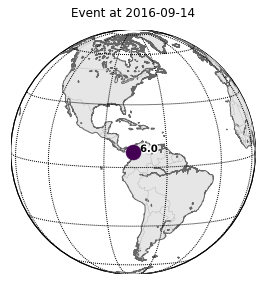

Instaseis Source:
	Origin Time      : 1970-01-01T00:00:00.000000Z
	Longitude        :  -76.2 deg
	Latitude         :    7.4 deg
	Depth            : 1.8e+01 km km
	Moment Magnitude :   5.98
	Scalar Moment    :   1.16e+18 Nm
	Mrr              :   3.06e+17 Nm
	Mtt              :  -8.16e+17 Nm
	Mpp              :   5.10e+17 Nm
	Mrt              :  -6.81e+17 Nm
	Mrp              :  -5.37e+17 Nm
	Mtp              :  -2.90e+17 Nm



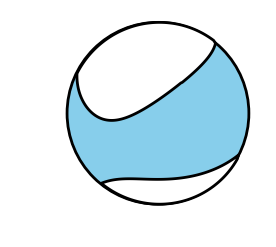

In [2]:
# Retrieve the event data
starttime=obspy.UTCDateTime(2016, 9, 11, 16)
endtime=obspy.UTCDateTime(2016, 9, 14, 4)
minmagnitude=5.9
maxmagnitude=6.1
eventid="GCMT:C201609140158A"
cat=event(starttime=starttime,endtime=endtime,minmagnitude=5.9, maxmagnitude=6.1)
# Make sure starttime and endtime include the complete time for all data (all stations)
starttime=obspy.UTCDateTime(2016, 9, 14, 1, 58, 10)
endtime=obspy.UTCDateTime(2016, 9, 14, 3, 58, 31)

# From work on the moment tensor solution
event_depth=20 #km.
event_latitude,event_longitude=7.236,-76.275

# Near Field / Regional Inversion

We will start doing an inversion just with the regional data.

In [3]:
#Read the data
DataDir='/Users/jeanbaptistetary/Documents/SSI/'
traces = obspy.read(DataDir+"2016-09-14-0151-59M.COL___318")
traces = traces.select(channel="HH*") # Channels with HN* or EH* not useable

# Remove some stations/traces if needed. 
# Stations
#     'ACON','ANIL','ANWB','ARGC','BAR2','BBAC','BBGH','BCIP','BET','BOAV','BRR','BRU2',
#     'CACAO','CBOC','CHI','CONO','CNGN','CRIN','CRJC','CRU','CUFI','CUM','DABV',
#     'DBB','ELA','FLO2','GARC','GCUF','GRGR','GRTK','GR1C','GUA','GUY2C','HEL','JTS',
#     'LCBC','LL1C','LL5C','LL6C','LPAZ',
#     'MACC','MAL','MAP','MARO','MTDJ','NIZA','NNA','NOR','OCA','OTAV',
#     'PAL','PAM','PAS2','PAYG','PNME','PRUE','PRV','PTB','PTLC','PTGC',
#     'RAC2C','ROSC','RUS','SDDR','SJC','SMAR','SOCV','SOL','SOTO','SPBC',
#     'TABC','TAM','TBTG','TEIG','TGUH','TUM','TUM3C',
#     'UPA','UPD2','URE','URI','VIL','YOT','ZAR'

# Stations to use for Mutata: HEL ZAR PTB NOR BRR CBOC UPD2 PAL
# Bad data it seems: DBB, SOL, URE, LCBC
# Stations to remove:
listOfTraces=[
    'ACON','ANIL','ANWB','ARGC','BAR2','BBAC','BBGH','BCIP','BET','BOAV','BRU2',
    'CACAO','CHI','CONO','CNGN','CRIN','CRJC','CRU','CUFI','CUM','DABV','DBB',
    'ELA','FLO2','GARC','GCUF','GRGR','GRTK','GR1C','GUA','GUY2C','JTS',
    'LCBC','LL1C','LL5C','LL6C','LPAZ',
    'MACC','MAL','MAP','MARO','MTDJ','NIZA','NNA','OCA','OTAV',
    'PAM','PAS2','PAYG','PNME','PRUE','PRV','PTLC','PTGC',
    'RAC2C','ROSC','RUS','SDDR','SJC','SMAR','SOCV','SOL','SOTO','SPBC',
    'TABC','TAM','TBTG','TEIG','TGUH','TUM','TUM3C',
    'UPA','URE','URI','VIL','YOT'
    ]

traces=removeTrace(traces,listOfTraces)
print(traces.__str__(extended=True))

traces=removeTraceLoc(traces,staname='PTB',loc='10')
traces=removeTraceLoc(traces,staname='NOR',loc='10')
traces=removeTraceLoc(traces,staname='PAL',loc='10')

print(traces.__str__(extended=True))


24 Trace(s) in Stream:
CM.ZAR.00.HHE  | 2016-09-14T01:51:54.598393Z - 2016-09-14T02:16:59.448393Z | 100.0 Hz, 150486 samples
RP.UPD2..HHN   | 2016-09-14T01:51:58.464999Z - 2016-09-14T02:16:59.504999Z | 100.0 Hz, 150105 samples
CM.HEL.00.HHN  | 2016-09-14T01:51:56.158393Z - 2016-09-14T02:17:02.668393Z | 100.0 Hz, 150652 samples
CM.CBOC.00.HHZ | 2016-09-14T01:51:57.858393Z - 2016-09-14T02:17:00.928393Z | 100.0 Hz, 150308 samples
CM.CBOC.00.HHE | 2016-09-14T01:51:57.588393Z - 2016-09-14T02:17:02.188393Z | 100.0 Hz, 150461 samples
CM.CBOC.00.HHN | 2016-09-14T01:51:56.268393Z - 2016-09-14T02:17:01.038393Z | 100.0 Hz, 150478 samples
CM.HEL.00.HHZ  | 2016-09-14T01:51:56.568393Z - 2016-09-14T02:17:02.058393Z | 100.0 Hz, 150550 samples
CM.PTB.00.HHZ  | 2016-09-14T01:51:54.888393Z - 2016-09-14T02:17:01.618393Z | 100.0 Hz, 150674 samples
CM.PTB.00.HHE  | 2016-09-14T01:51:56.558393Z - 2016-09-14T02:17:00.718393Z | 100.0 Hz, 150417 samples
CM.PTB.00.HHN  | 2016-09-14T01:51:56.378393Z - 2016-09-14T0

In [4]:
#Choose a home Directory for project (everything will be saved in this directory)
directory='/Users/jeanbaptistetary/Documents/SSI/'

#Name of the folder that will contain all the Near Field / Regional results.
projectName='NearField'

#Select init=True to initialize project folder tree, If the tree already exists select False 
#WARNING: IF TRUE THE EXISTING FOLDER "projectName" WILL BE DELETED!!!
InitProjectFolderTree(directory,projectName,init=False)

## NearField / Regional velocity model

The NearField / Regional velocity model is created. A Colombian velocity model based on Vargas, 2020 is taken as a reference. Completed at depth and for Q data by the ak135f model.

In [5]:
#Columns must be: Depth(km),Vs(km/s),Vp(km/s),Density(g/cm3),Qs,Qp
#For Colombia
NF_Vmod=np.array([[0.0,3.37,6.00,2.70,600,1480],
                  [15.0,3.76,6.70,2.92,600,1400],
                  [40.0,4.38,7.80,2.92,600,1370],
                  [50.0,4.43,7.89,3.53,394,950],
                  [189.0,4.73,8.31,3.43,80,200],
                  [360.0,4.84,8.74,3.33,150,370]])

#For stations outside Colombia
#NF_Vmod=np.array([[0.00,3.20,5.80,2.60,600.00,1480.00],
#               [3.30,3.20,5.80,2.60,600.00,1480.00],
#               [10.00,3.90,6.80,2.92,600.00,1370.00],
#               [18.00,4.31,7.89,3.53,394.00,950.00],
#               [189.00,4.73,8.31,3.43,80.00,200.00],
#               [360.00,4.84,8.74,3.33,150.00,370.00],
#               [410.00,5.12,9.36,3.93,160.00,410.00],
#               [510.00,5.29,9.70,3.92,170.00,420.00],
#               [610.00,5.38,10.03,3.92,170.00,425.00],
#               [660.66,6.19,11.03,4.38,540.00,1280.00],
#               [1749.67,6.77,12.43,5.02,450.00,1130.00],
#               [2839.33,7.34,13.83,5.75,275.00,725.00],
#               [2891.50,0.00,8.25,10.13,0.00,57822.00],
#               [3997.53,0.00,9.39,11.21,0.00,57822.00],
#               [5103.57,0.00,10.53,12.29,0.00,57822.00],
#               [5153.50,3.53,11.07,12.75,85.00,630.00],
#               [5736.90,3.61,11.18,12.90,85.00,610.00],
#               [6320.29,3.69,11.29,13.06,85.00,600.00]])


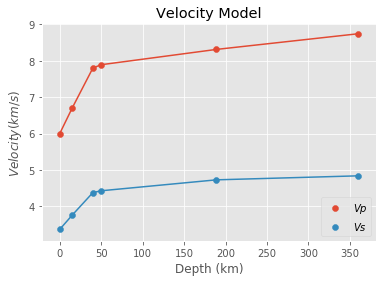

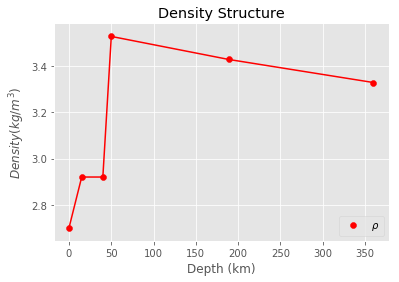

In [7]:
placeVelocityModel(directory,projectName,NF_Vmod,'NF-VelMod.mod')

## Data processing
We are going to remove the instrument response, cut the time window, taper, detrend, rotate and resample all of the traces.

Trace number 1/24 in stream traces
6 arrivals
	P phase arrival at 24.830 seconds
	P phase arrival at 26.003 seconds
	P phase arrival at 26.540 seconds
	S phase arrival at 43.063 seconds
	S phase arrival at 43.809 seconds
	S phase arrival at 44.724 seconds


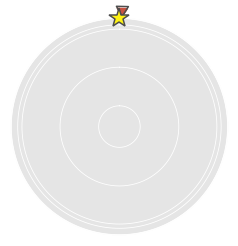

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


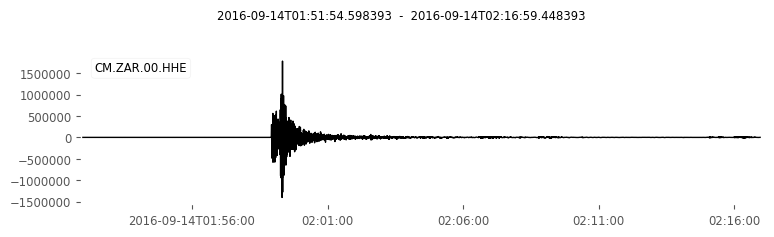

/anaconda2/envs/obspy/lib/python2.7/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


/anaconda2/envs/obspy/lib/python2.7/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


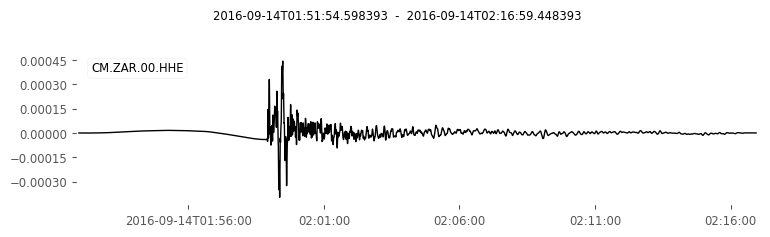

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


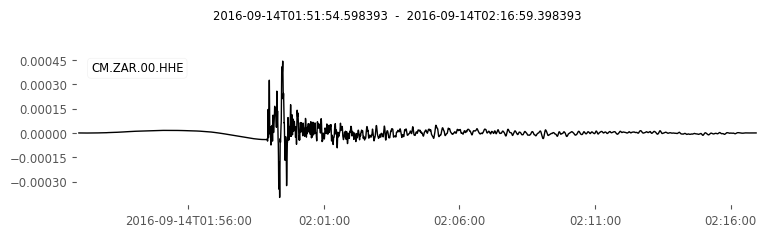

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


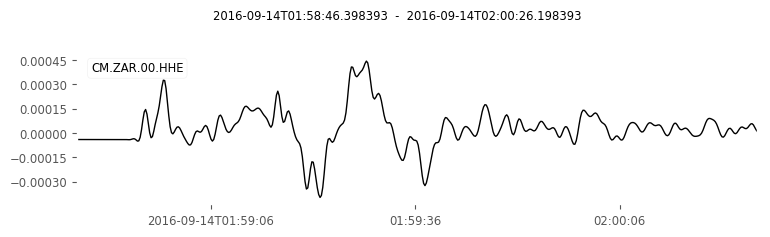

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


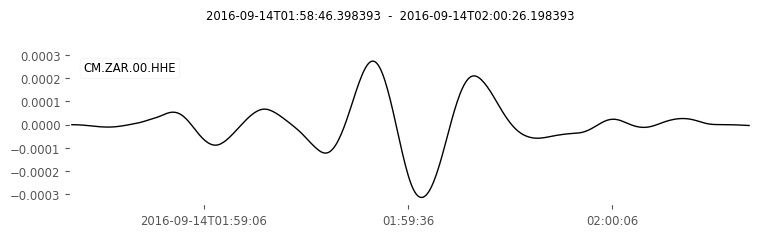

ZAR Trim start time: 2016-09-14T01:58:46.400279Z Trim end time: 2016-09-14T02:00:26.200279Z
ZAR Resampled to: dt= 0.2 number of points= 500
Trace number 2/24 in stream traces
6 arrivals
	P phase arrival at 34.934 seconds
	P phase arrival at 38.530 seconds
	P phase arrival at 38.835 seconds
	S phase arrival at 61.195 seconds
	S phase arrival at 64.958 seconds
	S phase arrival at 65.478 seconds


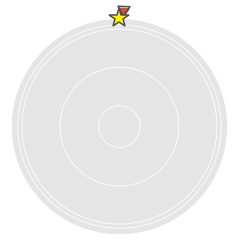

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


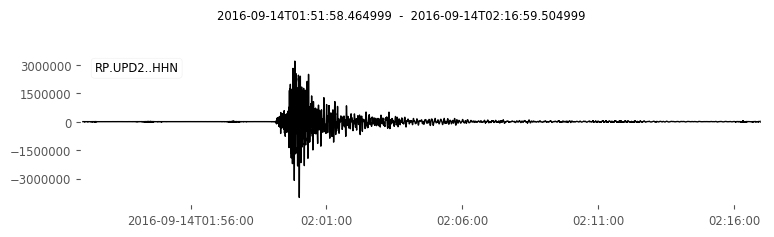

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


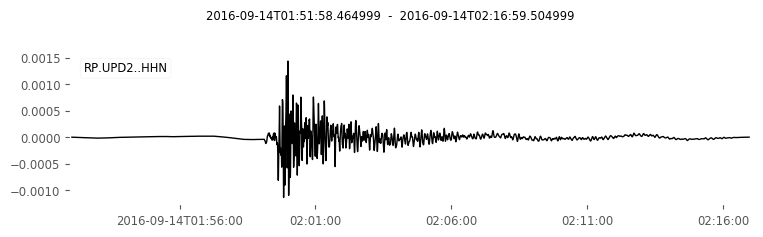

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


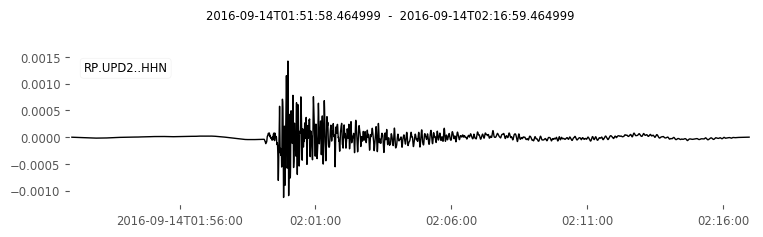

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


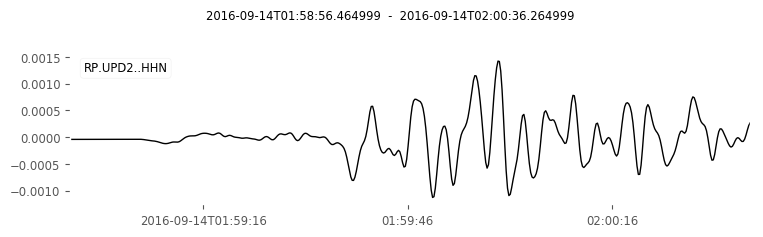

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


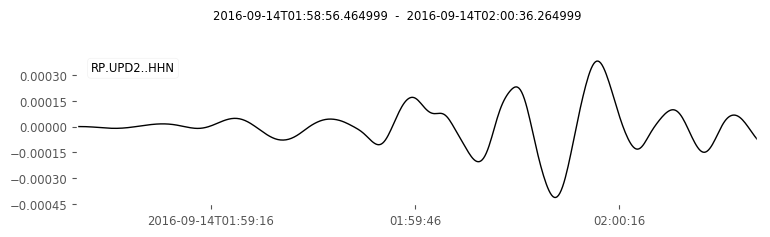

UPD2 Trim start time: 2016-09-14T01:58:56.503951Z Trim end time: 2016-09-14T02:00:36.303951Z
UPD2 Resampled to: dt= 0.2 number of points= 500
Trace number 3/24 in stream traces
6 arrivals
	P phase arrival at 22.722 seconds
	P phase arrival at 23.389 seconds
	P phase arrival at 24.013 seconds
	S phase arrival at 39.279 seconds
	S phase arrival at 39.396 seconds
	S phase arrival at 40.459 seconds


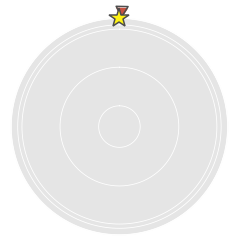

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


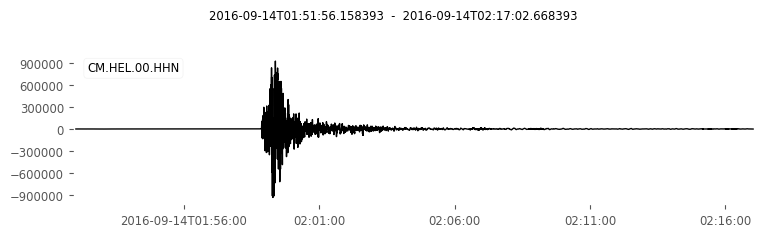

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


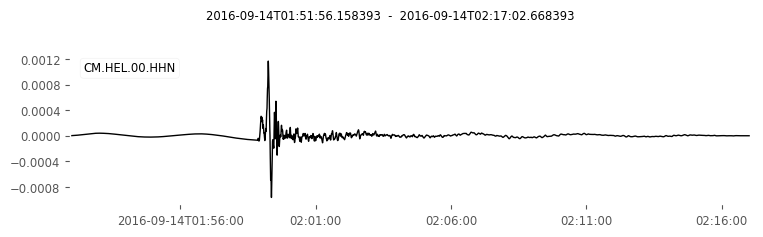

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


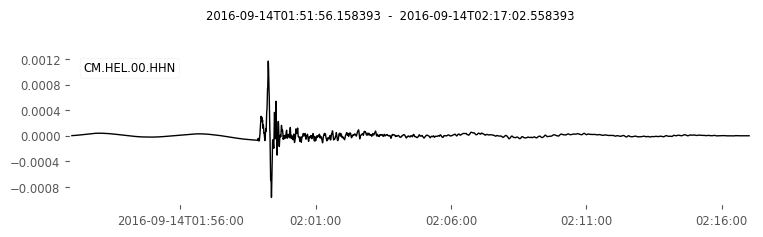

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


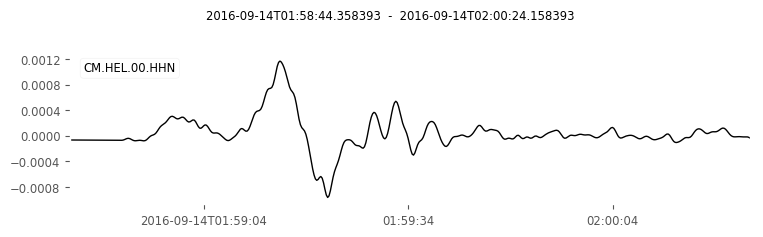

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


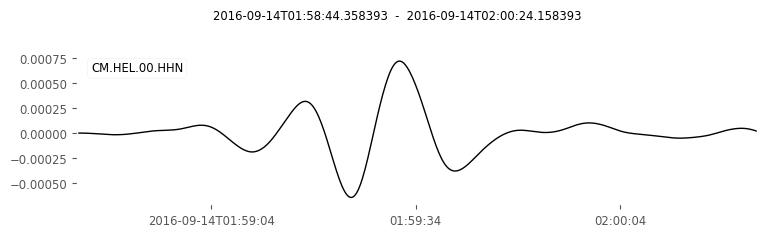

HEL Trim start time: 2016-09-14T01:58:44.292231Z Trim end time: 2016-09-14T02:00:24.092231Z
HEL Resampled to: dt= 0.2 number of points= 500
Trace number 4/24 in stream traces
6 arrivals
	P phase arrival at 24.267 seconds
	P phase arrival at 25.305 seconds
	P phase arrival at 25.863 seconds
	S phase arrival at 42.052 seconds
	S phase arrival at 42.630 seconds
	S phase arrival at 43.582 seconds


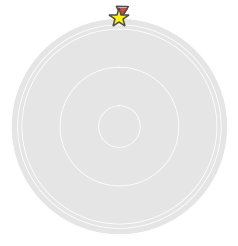

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


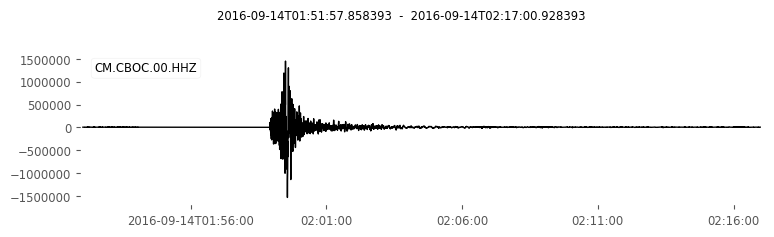

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


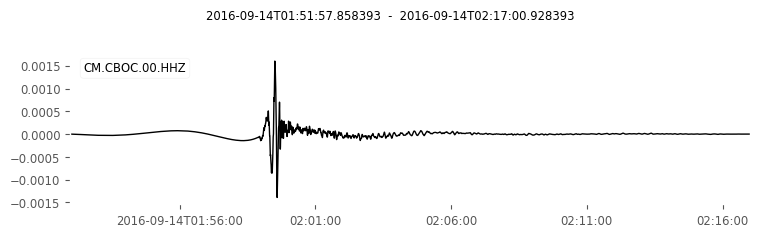

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


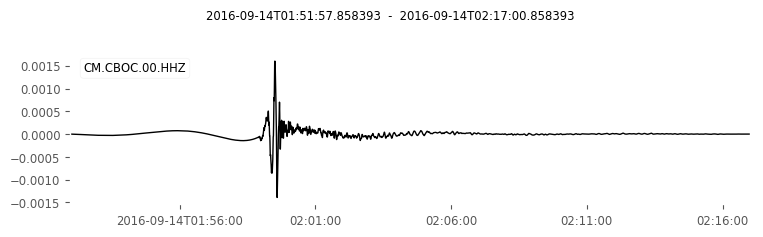

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


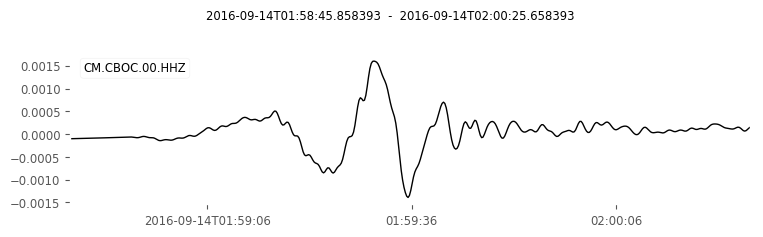

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


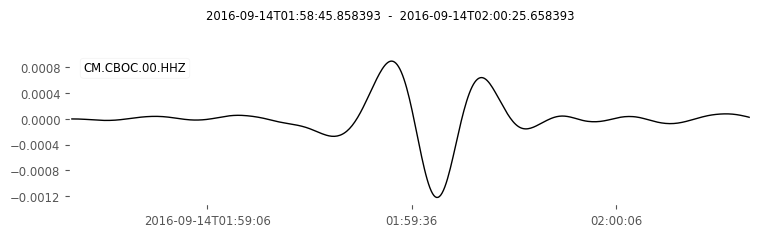

CBOC Trim start time: 2016-09-14T01:58:45.837200Z Trim end time: 2016-09-14T02:00:25.637200Z
CBOC Resampled to: dt= 0.2 number of points= 500
Trace number 5/24 in stream traces
6 arrivals
	P phase arrival at 24.267 seconds
	P phase arrival at 25.305 seconds
	P phase arrival at 25.863 seconds
	S phase arrival at 42.052 seconds
	S phase arrival at 42.630 seconds
	S phase arrival at 43.582 seconds


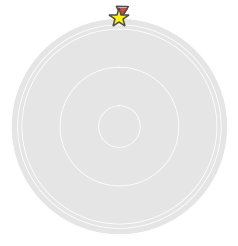

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


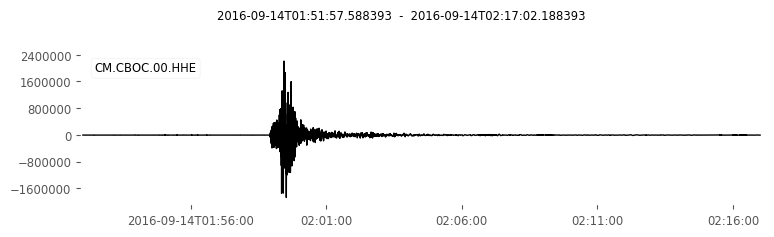

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


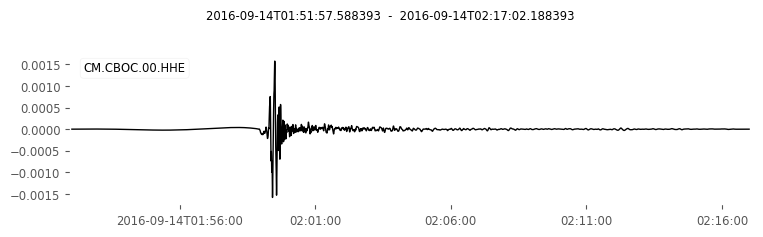

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


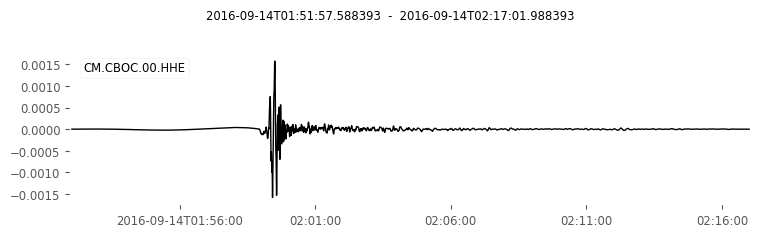

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


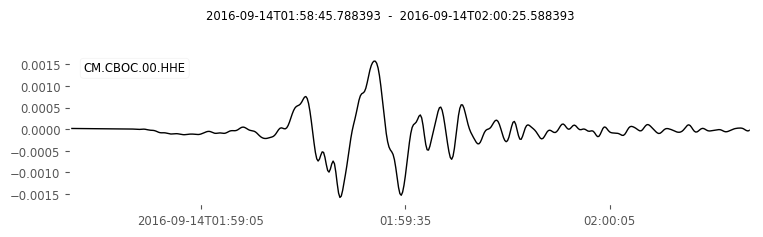

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


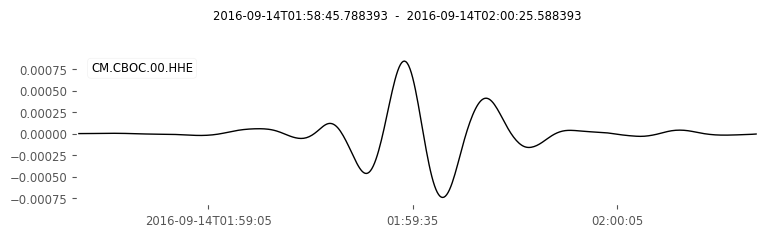

CBOC Trim start time: 2016-09-14T01:58:45.837200Z Trim end time: 2016-09-14T02:00:25.637200Z
CBOC Resampled to: dt= 0.2 number of points= 500
Trace number 6/24 in stream traces
6 arrivals
	P phase arrival at 24.267 seconds
	P phase arrival at 25.305 seconds
	P phase arrival at 25.863 seconds
	S phase arrival at 42.052 seconds
	S phase arrival at 42.630 seconds
	S phase arrival at 43.582 seconds


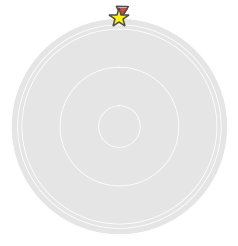

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


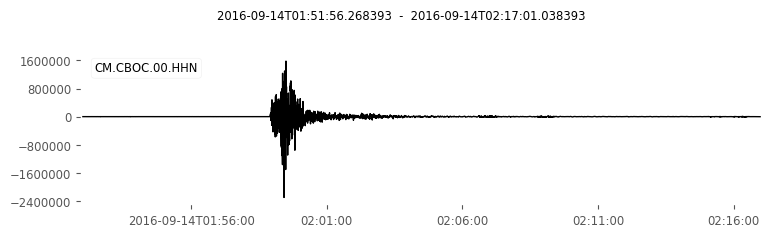

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


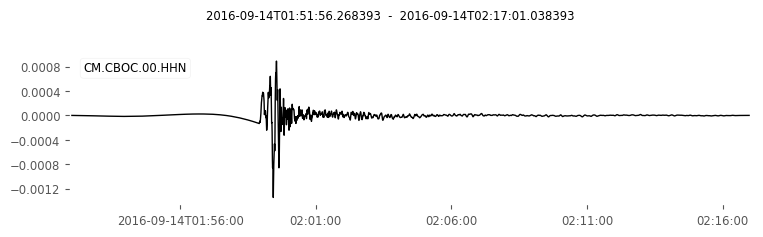

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


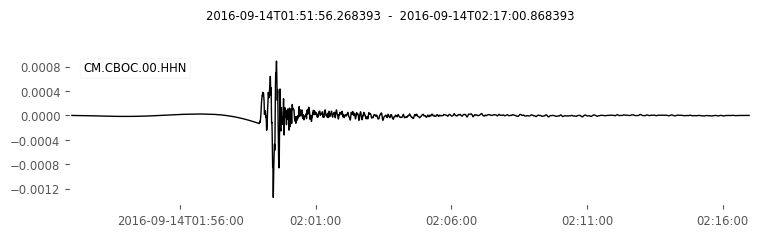

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


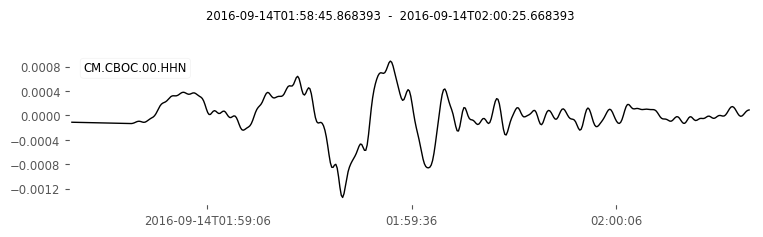

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


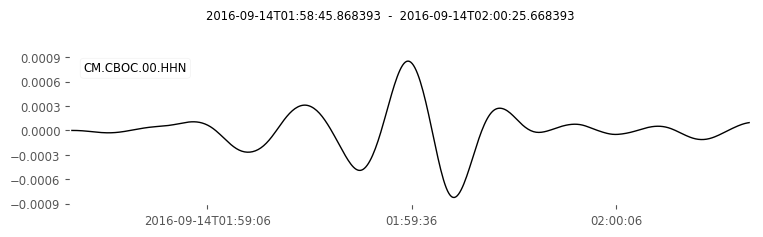

CBOC Trim start time: 2016-09-14T01:58:45.837200Z Trim end time: 2016-09-14T02:00:25.637200Z
CBOC Resampled to: dt= 0.2 number of points= 500
Trace number 7/24 in stream traces
6 arrivals
	P phase arrival at 22.722 seconds
	P phase arrival at 23.389 seconds
	P phase arrival at 24.013 seconds
	S phase arrival at 39.279 seconds
	S phase arrival at 39.396 seconds
	S phase arrival at 40.459 seconds


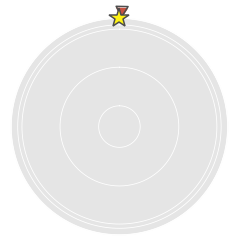

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


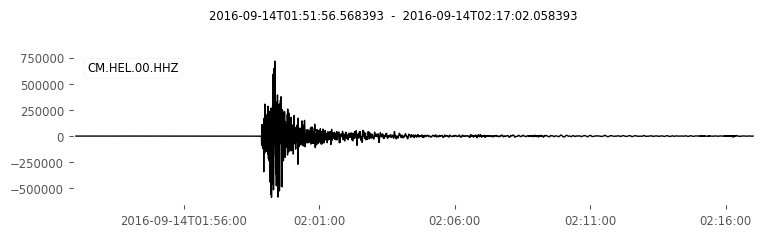

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


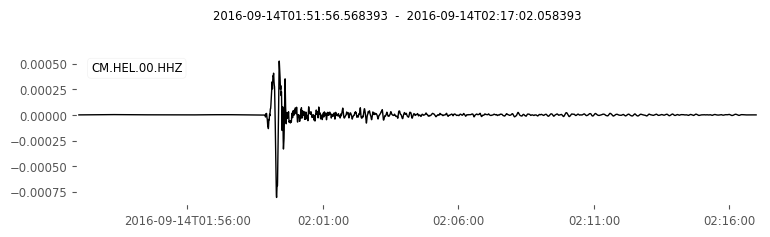

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


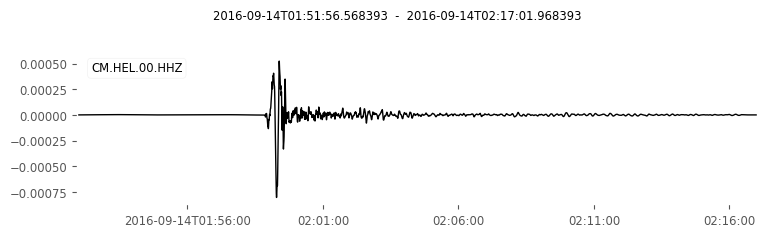

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


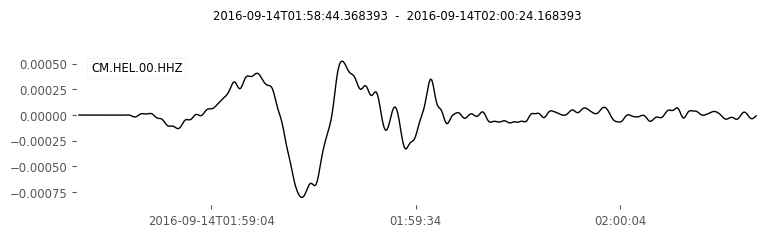

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


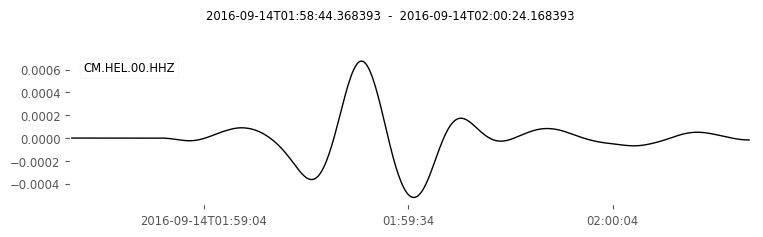

HEL Trim start time: 2016-09-14T01:58:44.292231Z Trim end time: 2016-09-14T02:00:24.092231Z
HEL Resampled to: dt= 0.2 number of points= 500
Trace number 8/24 in stream traces
6 arrivals
	P phase arrival at 31.804 seconds
	P phase arrival at 34.650 seconds
	P phase arrival at 35.006 seconds
	S phase arrival at 55.578 seconds
	S phase arrival at 58.407 seconds
	S phase arrival at 59.015 seconds


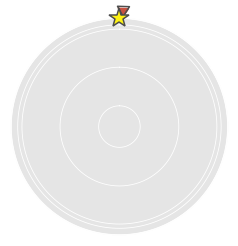

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


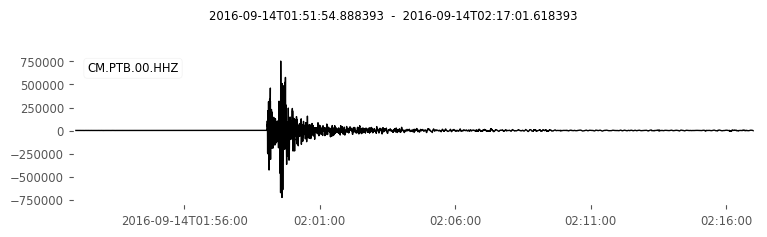

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


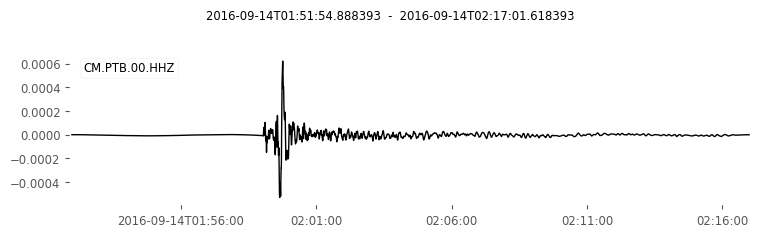

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


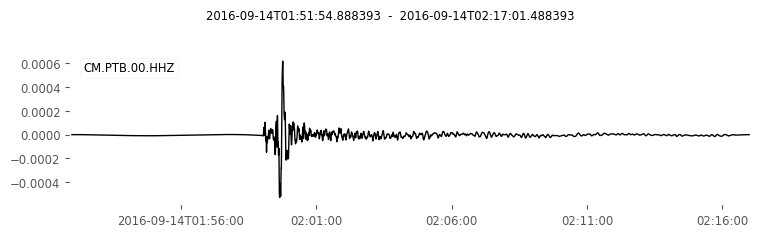

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


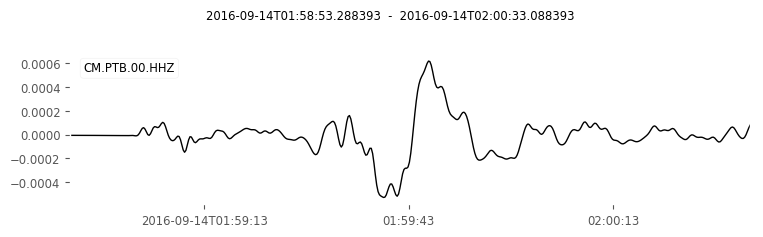

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


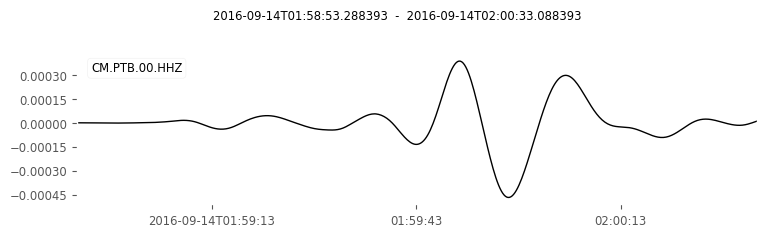

PTB Trim start time: 2016-09-14T01:58:53.374220Z Trim end time: 2016-09-14T02:00:33.174220Z
PTB Resampled to: dt= 0.2 number of points= 500
Trace number 9/24 in stream traces
6 arrivals
	P phase arrival at 31.804 seconds
	P phase arrival at 34.650 seconds
	P phase arrival at 35.006 seconds
	S phase arrival at 55.578 seconds
	S phase arrival at 58.407 seconds
	S phase arrival at 59.015 seconds


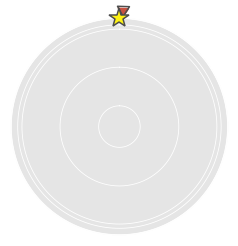

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


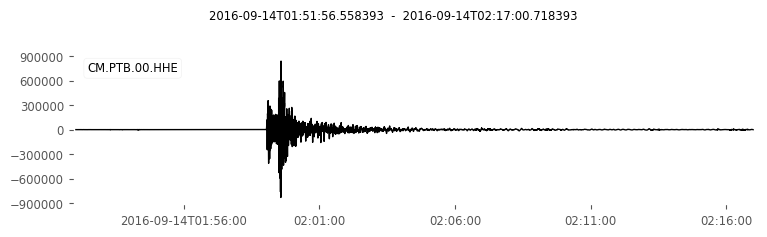

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


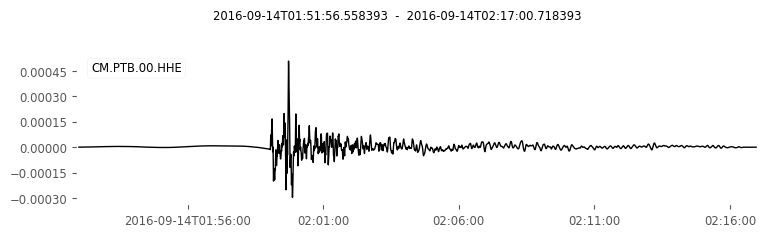

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


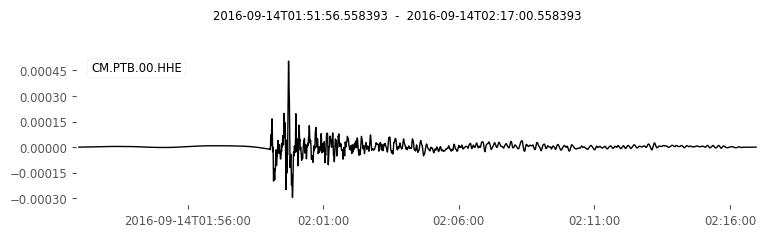

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


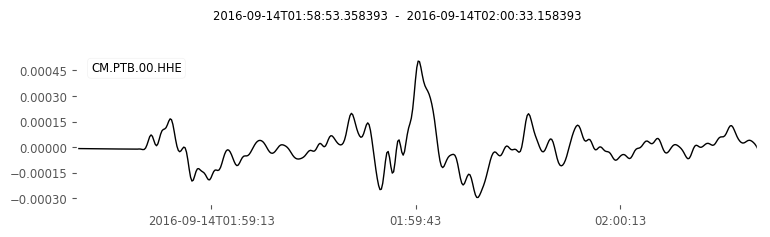

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


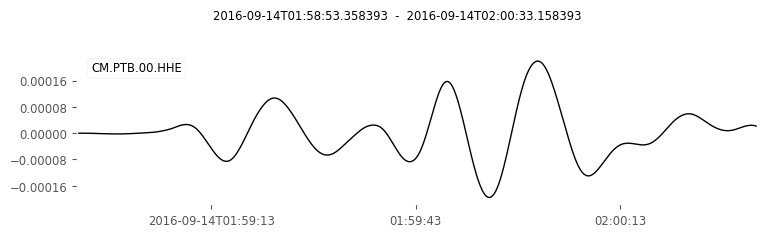

PTB Trim start time: 2016-09-14T01:58:53.374220Z Trim end time: 2016-09-14T02:00:33.174220Z
PTB Resampled to: dt= 0.2 number of points= 500
Trace number 10/24 in stream traces
6 arrivals
	P phase arrival at 31.804 seconds
	P phase arrival at 34.650 seconds
	P phase arrival at 35.006 seconds
	S phase arrival at 55.578 seconds
	S phase arrival at 58.407 seconds
	S phase arrival at 59.015 seconds


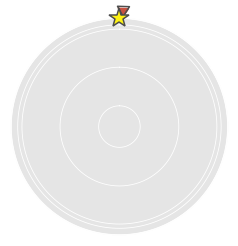

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


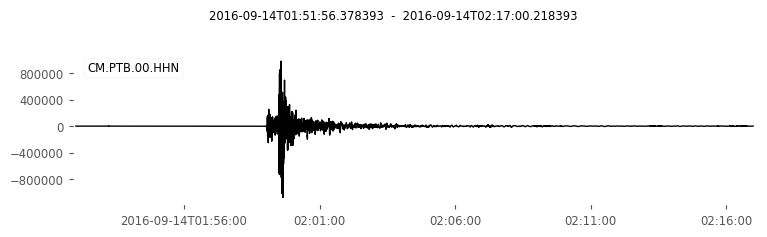

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


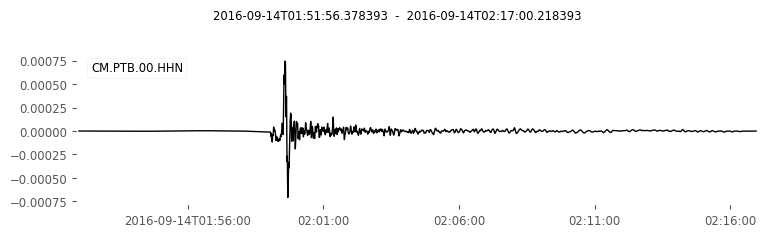

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


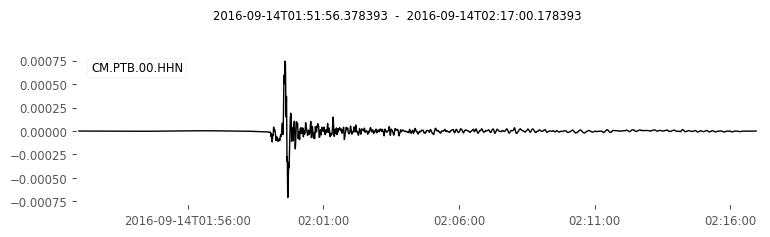

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


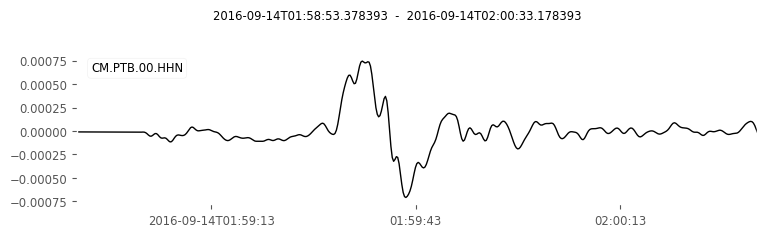

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


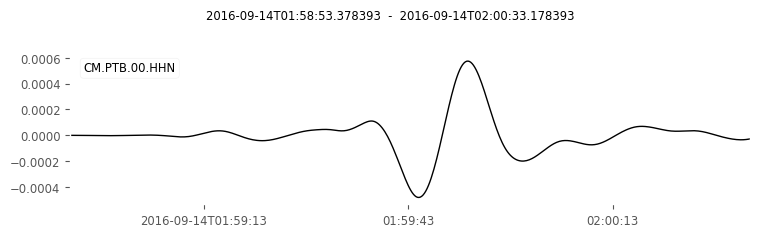

PTB Trim start time: 2016-09-14T01:58:53.374220Z Trim end time: 2016-09-14T02:00:33.174220Z
PTB Resampled to: dt= 0.2 number of points= 500
Trace number 11/24 in stream traces
6 arrivals
	P phase arrival at 35.077 seconds
	P phase arrival at 38.707 seconds
	P phase arrival at 39.010 seconds
	S phase arrival at 61.451 seconds
	S phase arrival at 65.257 seconds
	S phase arrival at 65.773 seconds


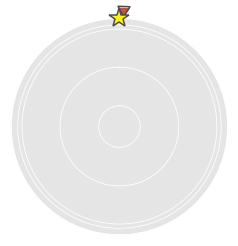

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


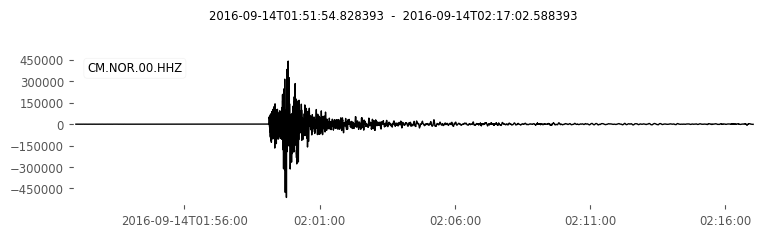

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


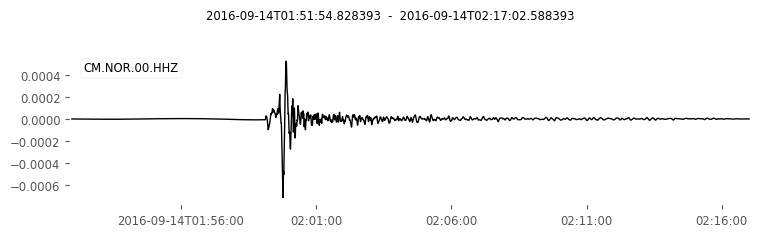

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


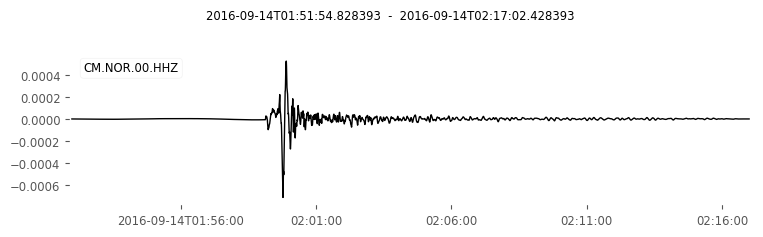

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


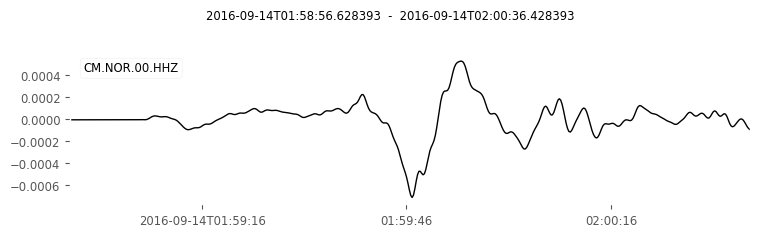

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


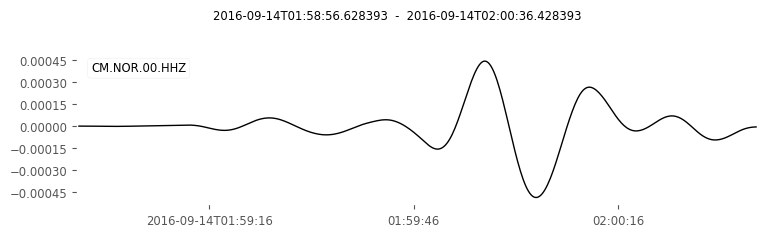

NOR Trim start time: 2016-09-14T01:58:56.646840Z Trim end time: 2016-09-14T02:00:36.446840Z
NOR Resampled to: dt= 0.2 number of points= 500
Trace number 12/24 in stream traces
6 arrivals
	P phase arrival at 35.077 seconds
	P phase arrival at 38.707 seconds
	P phase arrival at 39.010 seconds
	S phase arrival at 61.451 seconds
	S phase arrival at 65.257 seconds
	S phase arrival at 65.773 seconds


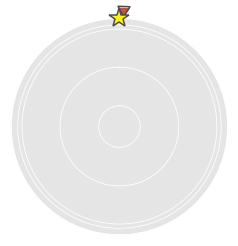

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


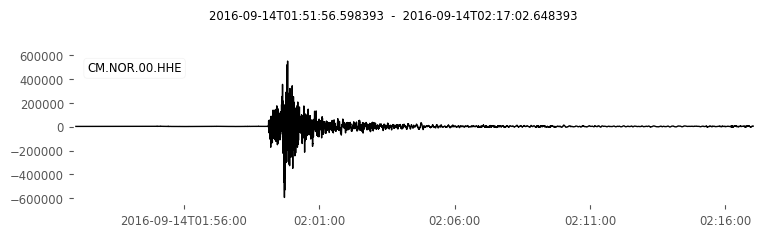

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


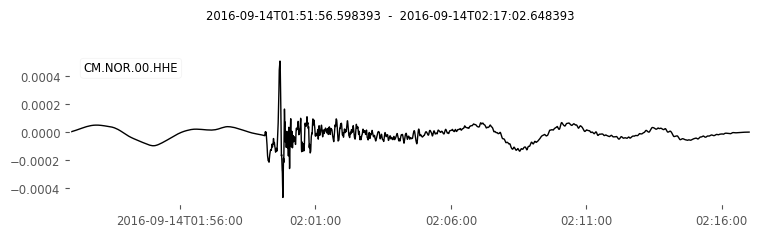

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


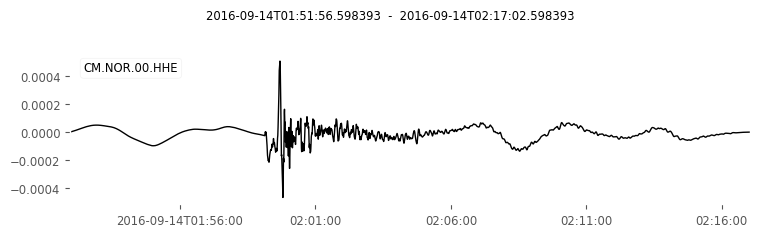

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


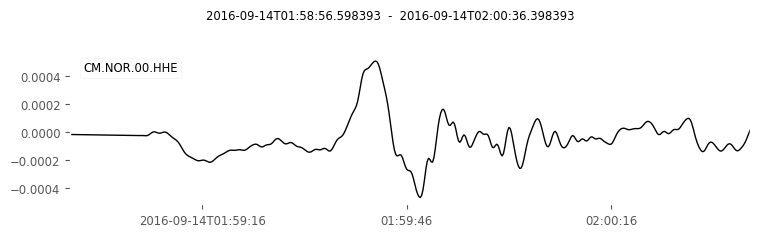

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


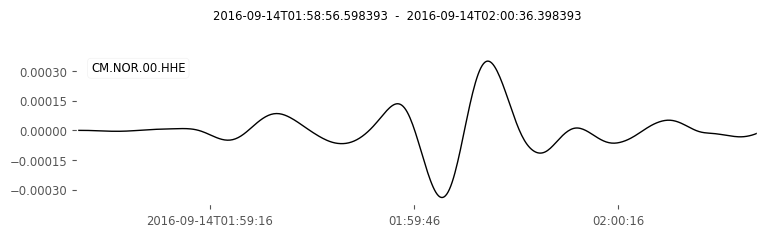

NOR Trim start time: 2016-09-14T01:58:56.646840Z Trim end time: 2016-09-14T02:00:36.446840Z
NOR Resampled to: dt= 0.2 number of points= 500
Trace number 13/24 in stream traces
6 arrivals
	P phase arrival at 35.077 seconds
	P phase arrival at 38.707 seconds
	P phase arrival at 39.010 seconds
	S phase arrival at 61.451 seconds
	S phase arrival at 65.257 seconds
	S phase arrival at 65.773 seconds


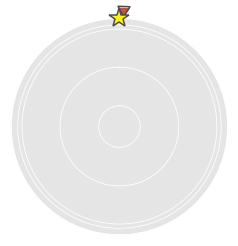

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


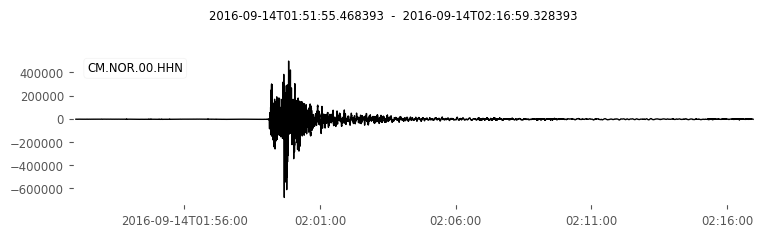

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


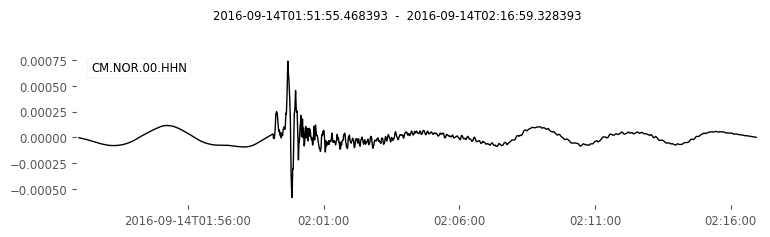

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


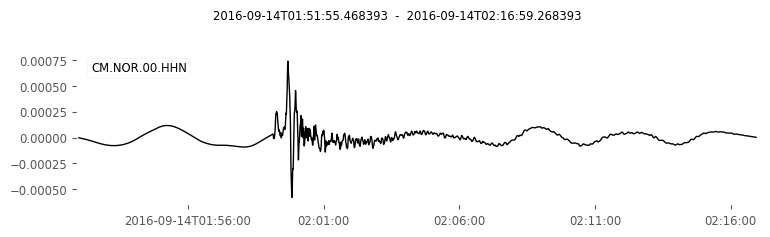

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


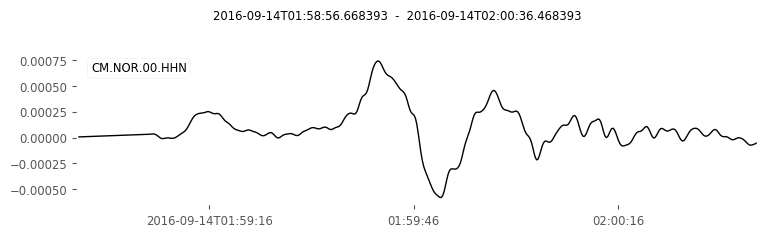

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


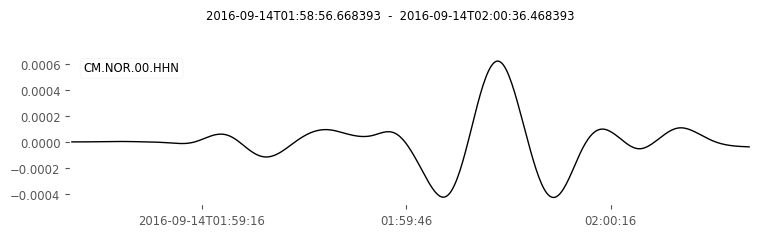

NOR Trim start time: 2016-09-14T01:58:56.646840Z Trim end time: 2016-09-14T02:00:36.446840Z
NOR Resampled to: dt= 0.2 number of points= 500
Trace number 14/24 in stream traces
6 arrivals
	P phase arrival at 37.076 seconds
	P phase arrival at 41.185 seconds
	P phase arrival at 41.461 seconds
	S phase arrival at 65.038 seconds
	S phase arrival at 69.441 seconds
	S phase arrival at 69.911 seconds


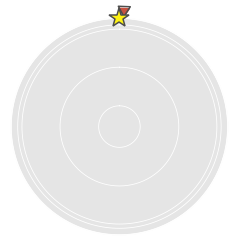

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


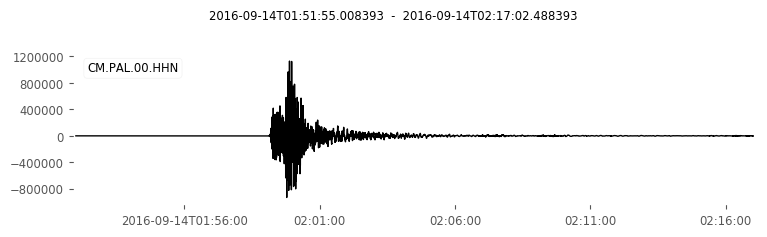

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


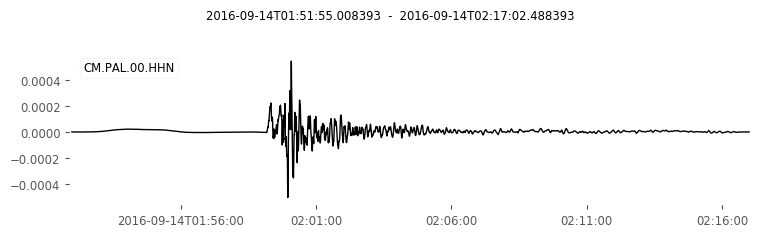

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


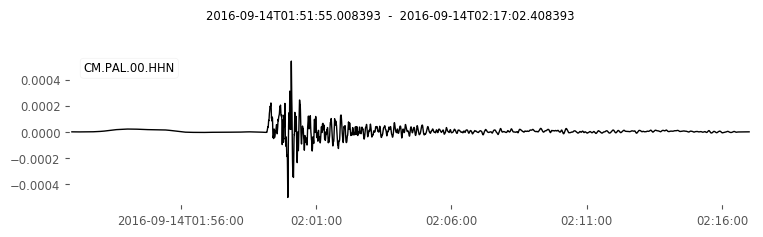

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


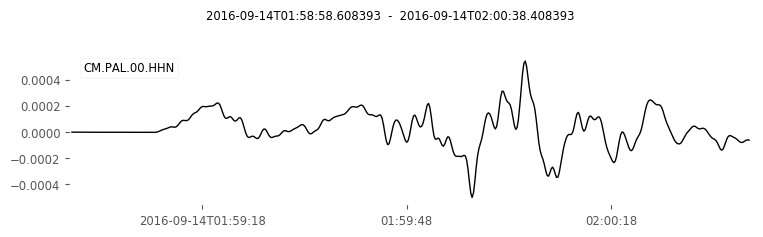

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


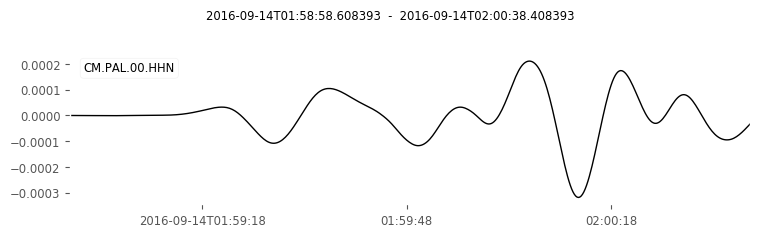

PAL Trim start time: 2016-09-14T01:58:58.645621Z Trim end time: 2016-09-14T02:00:38.445621Z
PAL Resampled to: dt= 0.2 number of points= 500
Trace number 15/24 in stream traces
6 arrivals
	P phase arrival at 37.076 seconds
	P phase arrival at 41.185 seconds
	P phase arrival at 41.461 seconds
	S phase arrival at 65.038 seconds
	S phase arrival at 69.441 seconds
	S phase arrival at 69.911 seconds


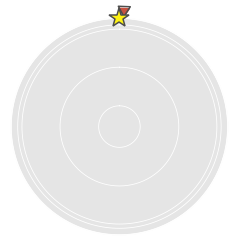

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


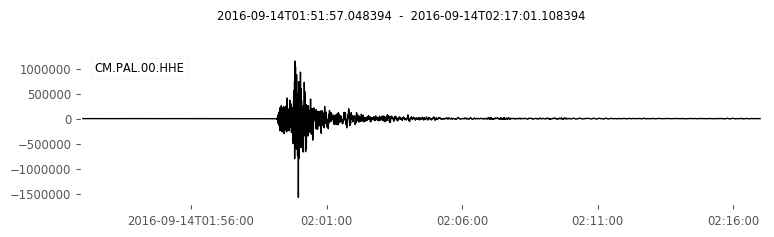

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


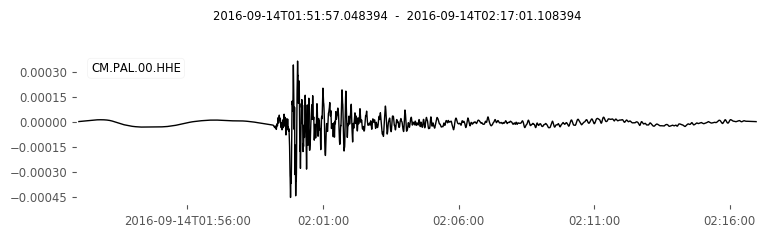

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


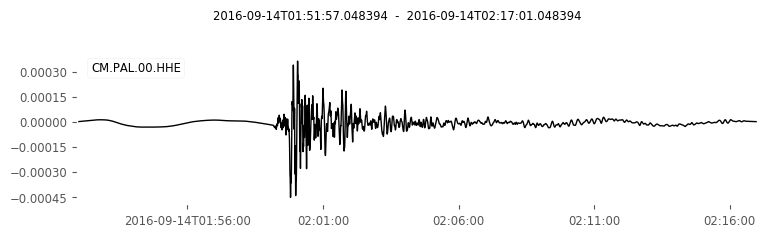

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


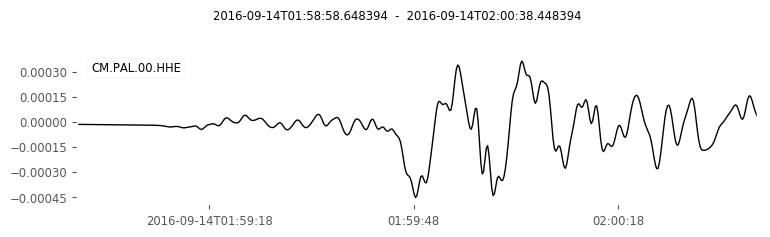

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


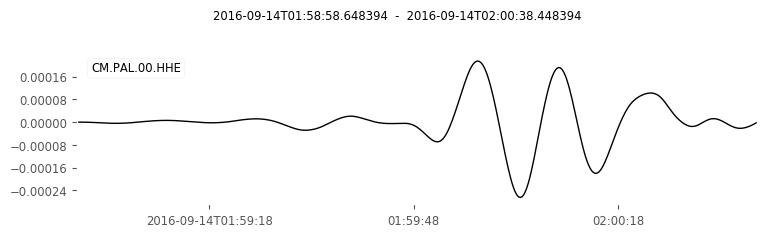

PAL Trim start time: 2016-09-14T01:58:58.645621Z Trim end time: 2016-09-14T02:00:38.445621Z
PAL Resampled to: dt= 0.2 number of points= 500
Trace number 16/24 in stream traces
6 arrivals
	P phase arrival at 37.076 seconds
	P phase arrival at 41.185 seconds
	P phase arrival at 41.461 seconds
	S phase arrival at 65.038 seconds
	S phase arrival at 69.441 seconds
	S phase arrival at 69.911 seconds


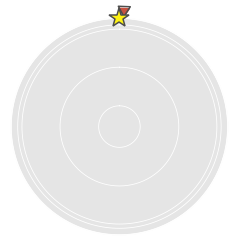

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


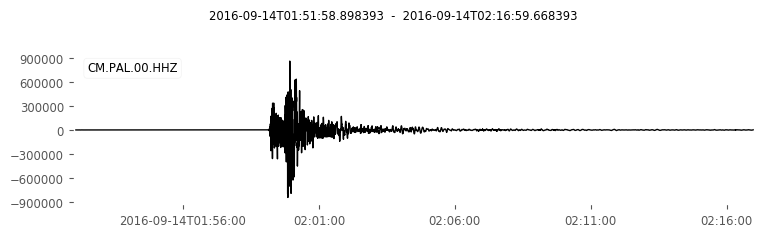

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


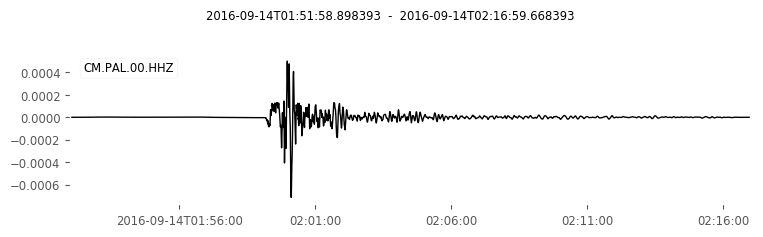

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


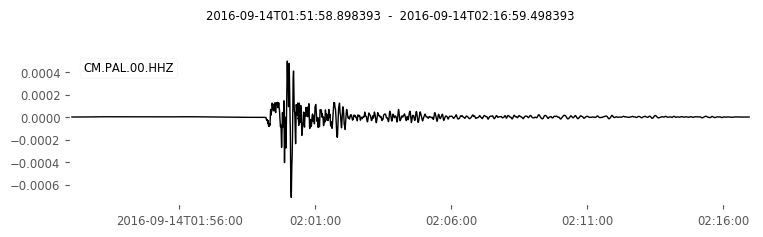

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


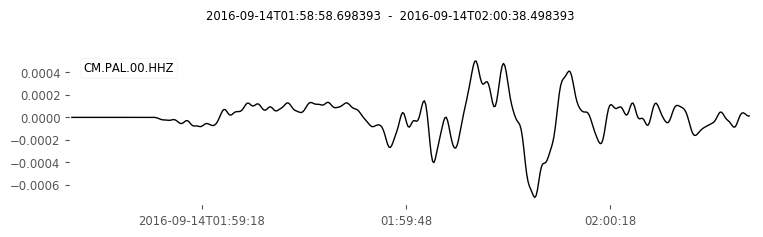

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


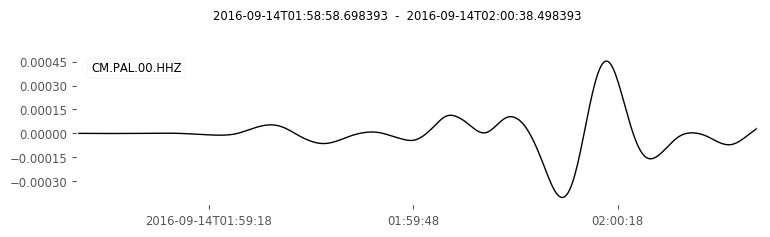

PAL Trim start time: 2016-09-14T01:58:58.645621Z Trim end time: 2016-09-14T02:00:38.445621Z
PAL Resampled to: dt= 0.2 number of points= 500
Trace number 17/24 in stream traces
6 arrivals
	P phase arrival at 22.722 seconds
	P phase arrival at 23.389 seconds
	P phase arrival at 24.013 seconds
	S phase arrival at 39.279 seconds
	S phase arrival at 39.396 seconds
	S phase arrival at 40.459 seconds


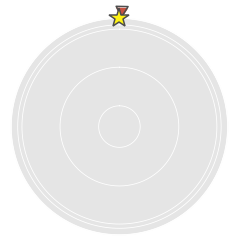

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


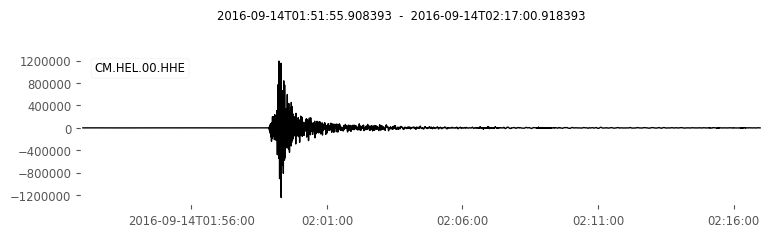

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


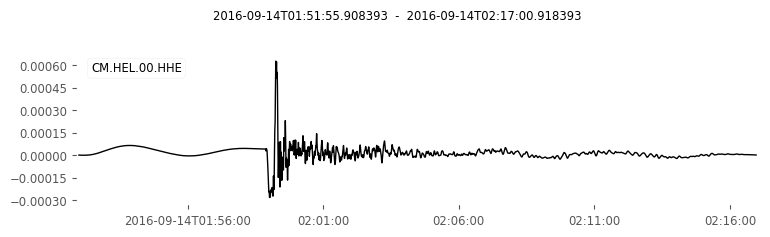

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


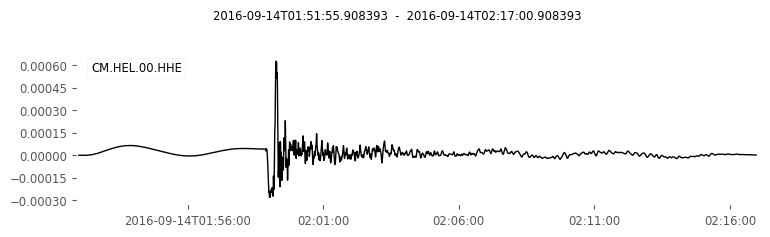

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


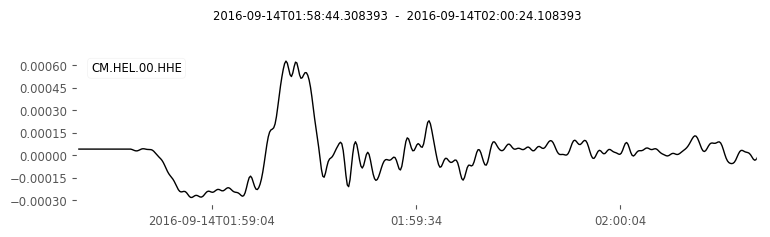

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


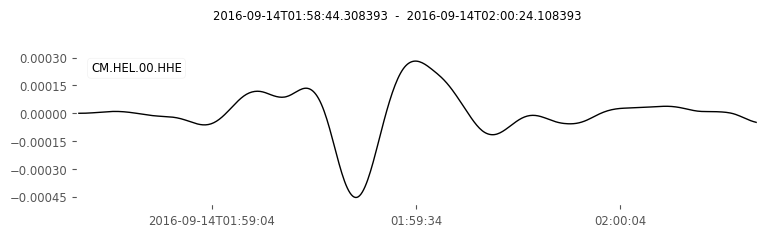

HEL Trim start time: 2016-09-14T01:58:44.292231Z Trim end time: 2016-09-14T02:00:24.092231Z
HEL Resampled to: dt= 0.2 number of points= 500
Trace number 18/24 in stream traces
6 arrivals
	P phase arrival at 24.830 seconds
	P phase arrival at 26.003 seconds
	P phase arrival at 26.540 seconds
	S phase arrival at 43.063 seconds
	S phase arrival at 43.809 seconds
	S phase arrival at 44.724 seconds


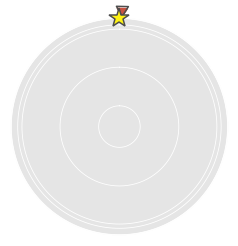

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


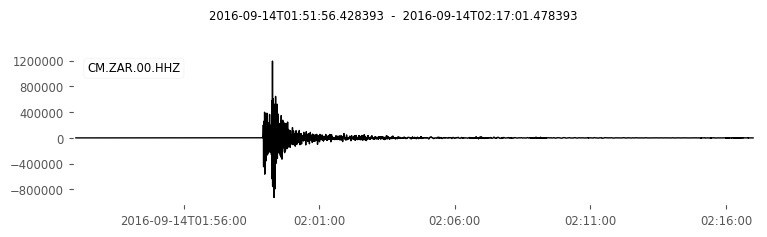

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


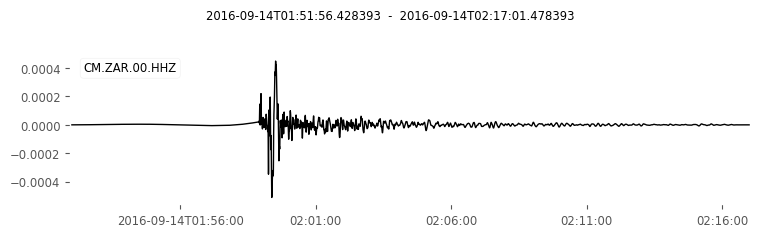

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


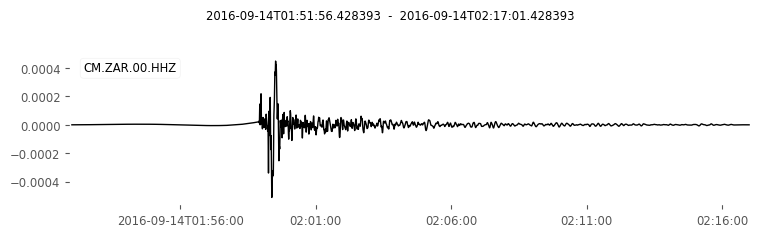

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


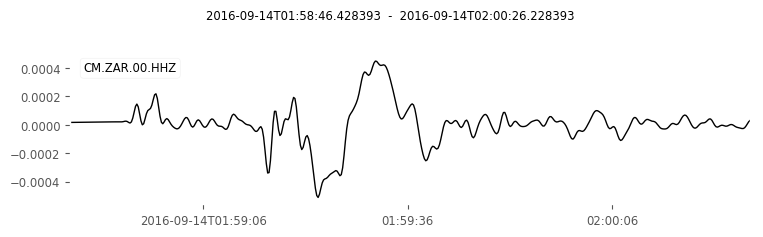

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


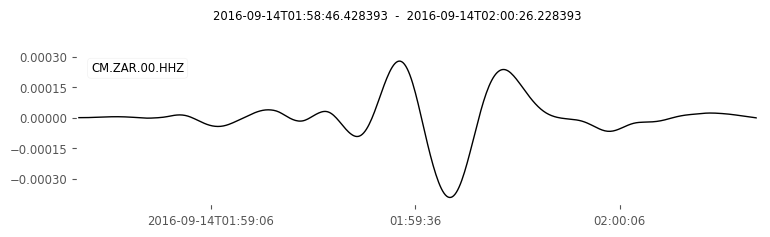

ZAR Trim start time: 2016-09-14T01:58:46.400279Z Trim end time: 2016-09-14T02:00:26.200279Z
ZAR Resampled to: dt= 0.2 number of points= 500
Trace number 19/24 in stream traces
6 arrivals
	P phase arrival at 24.830 seconds
	P phase arrival at 26.003 seconds
	P phase arrival at 26.540 seconds
	S phase arrival at 43.063 seconds
	S phase arrival at 43.809 seconds
	S phase arrival at 44.724 seconds


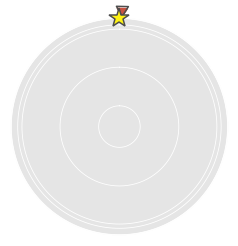

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


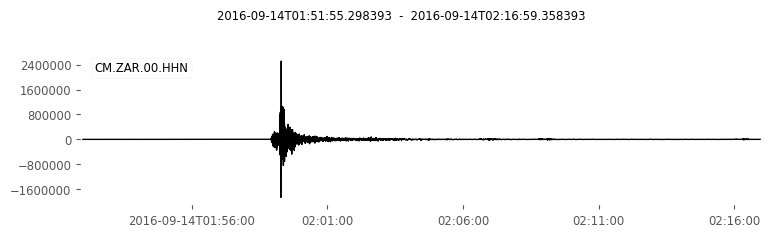

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


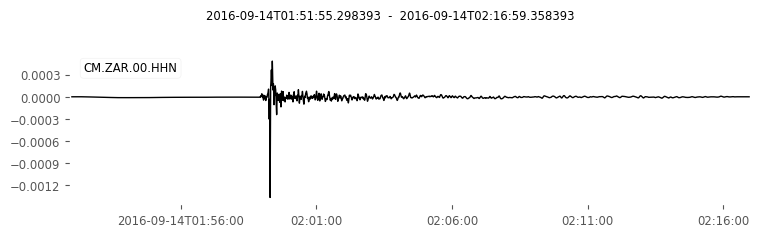

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


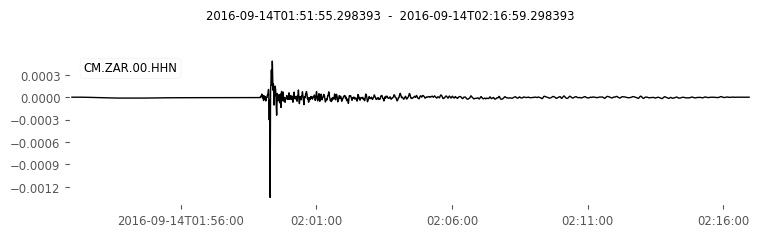

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


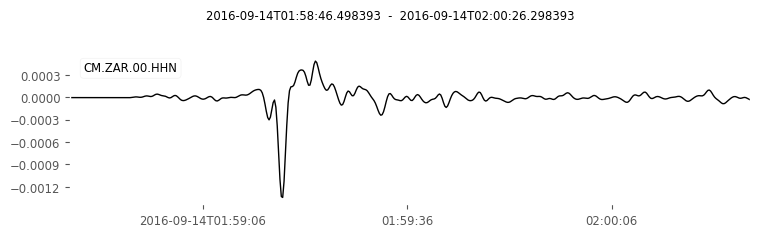

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


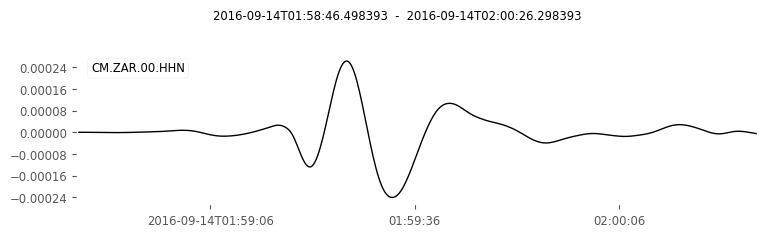

ZAR Trim start time: 2016-09-14T01:58:46.400279Z Trim end time: 2016-09-14T02:00:26.200279Z
ZAR Resampled to: dt= 0.2 number of points= 500
Trace number 20/24 in stream traces
6 arrivals
	P phase arrival at 40.257 seconds
	P phase arrival at 45.130 seconds
	P phase arrival at 45.370 seconds
	S phase arrival at 70.748 seconds
	S phase arrival at 76.101 seconds
	S phase arrival at 76.508 seconds


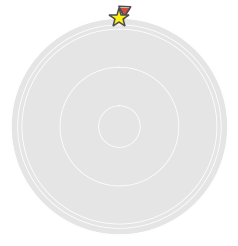

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


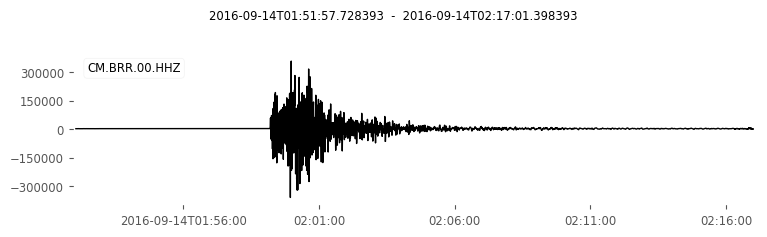

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


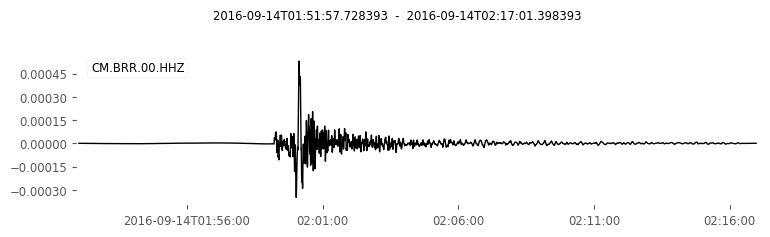

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


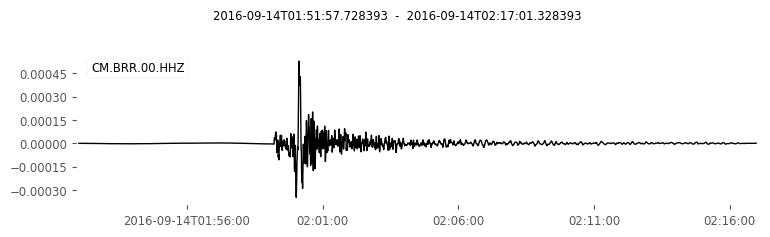

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


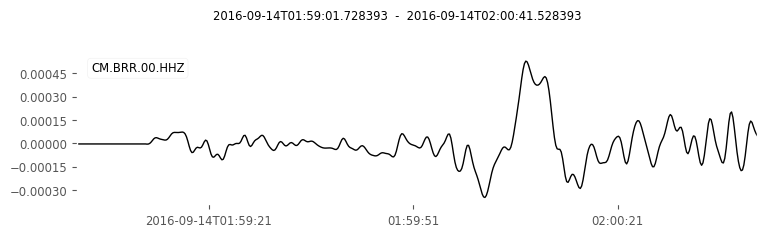

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


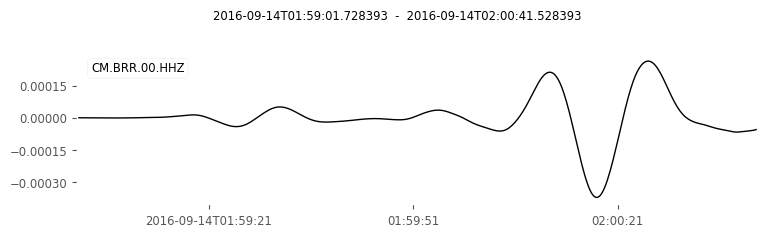

BRR Trim start time: 2016-09-14T01:59:01.827293Z Trim end time: 2016-09-14T02:00:41.627293Z
BRR Resampled to: dt= 0.2 number of points= 500
Trace number 21/24 in stream traces
6 arrivals
	P phase arrival at 34.934 seconds
	P phase arrival at 38.530 seconds
	P phase arrival at 38.835 seconds
	S phase arrival at 61.195 seconds
	S phase arrival at 64.958 seconds
	S phase arrival at 65.478 seconds


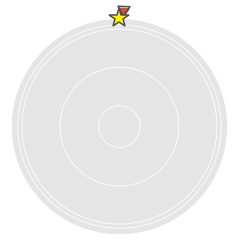

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


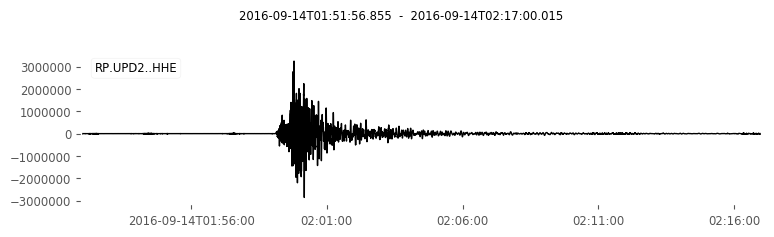

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


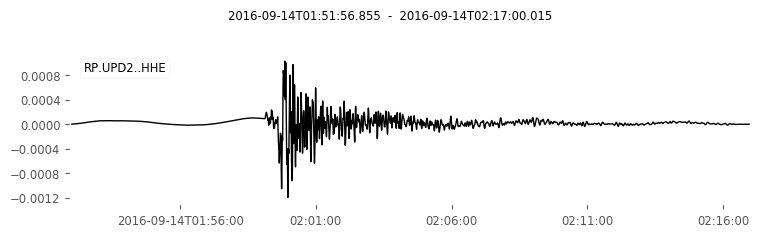

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


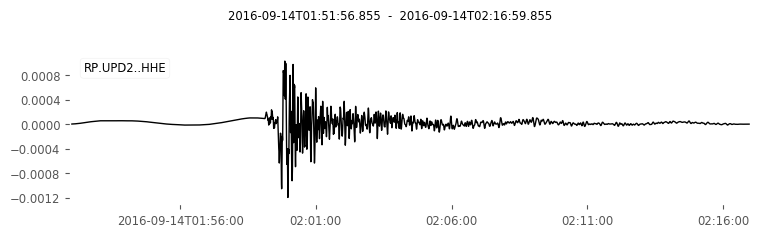

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


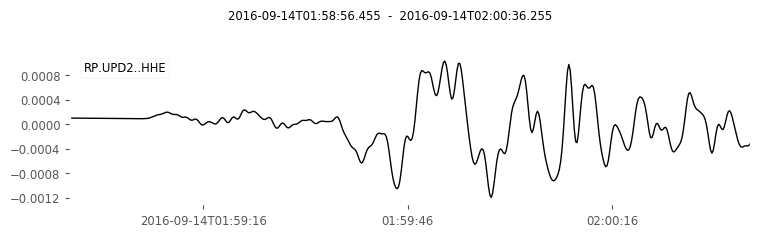

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


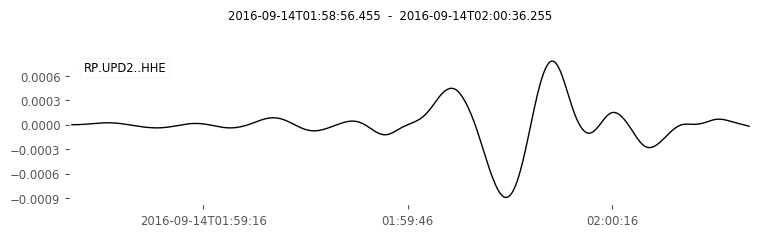

UPD2 Trim start time: 2016-09-14T01:58:56.503951Z Trim end time: 2016-09-14T02:00:36.303951Z
UPD2 Resampled to: dt= 0.2 number of points= 500
Trace number 22/24 in stream traces
6 arrivals
	P phase arrival at 40.257 seconds
	P phase arrival at 45.130 seconds
	P phase arrival at 45.370 seconds
	S phase arrival at 70.748 seconds
	S phase arrival at 76.101 seconds
	S phase arrival at 76.508 seconds


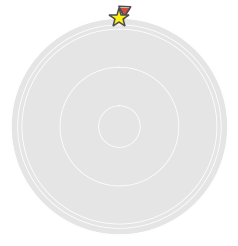

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


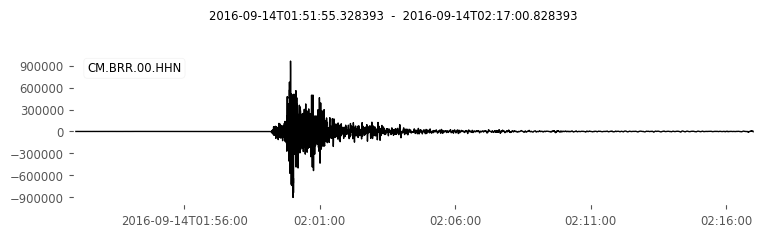

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


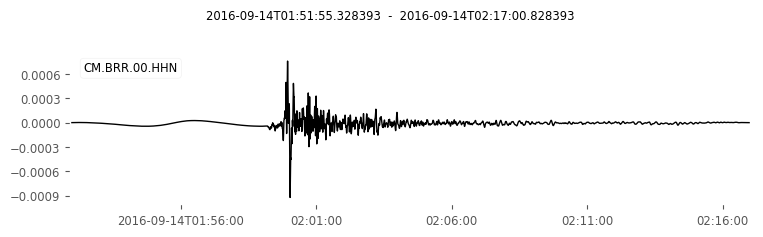

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


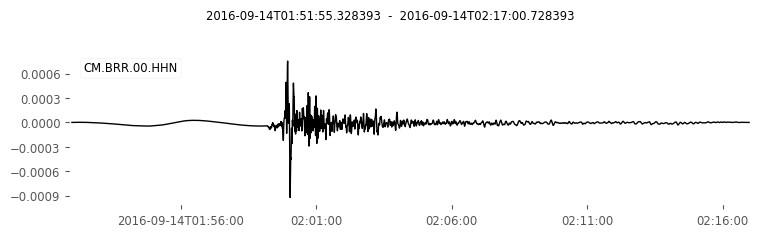

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


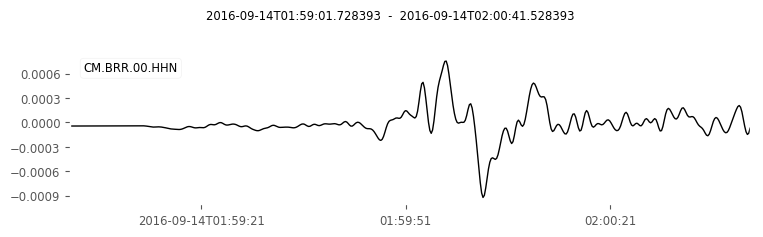

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


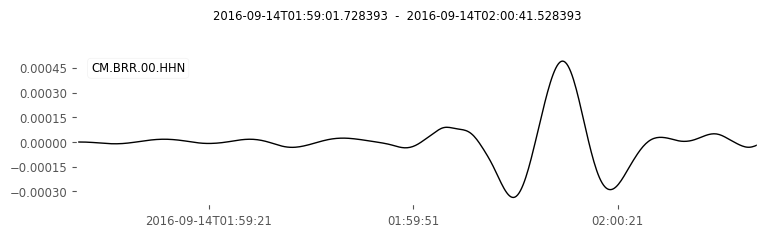

BRR Trim start time: 2016-09-14T01:59:01.827293Z Trim end time: 2016-09-14T02:00:41.627293Z
BRR Resampled to: dt= 0.2 number of points= 500
Trace number 23/24 in stream traces
6 arrivals
	P phase arrival at 34.934 seconds
	P phase arrival at 38.530 seconds
	P phase arrival at 38.835 seconds
	S phase arrival at 61.195 seconds
	S phase arrival at 64.958 seconds
	S phase arrival at 65.478 seconds


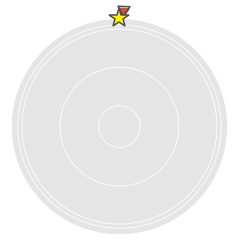

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


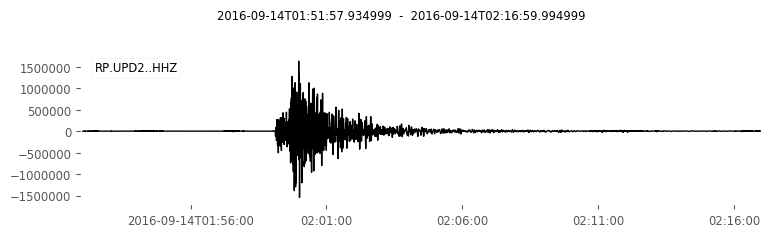

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


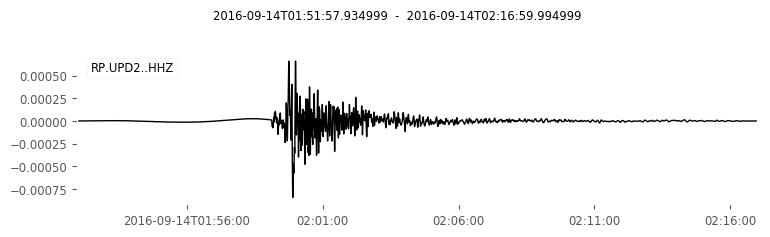

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


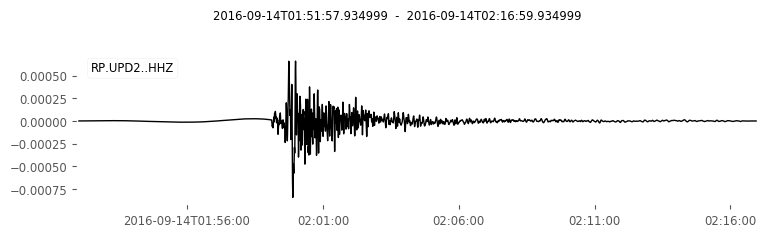

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


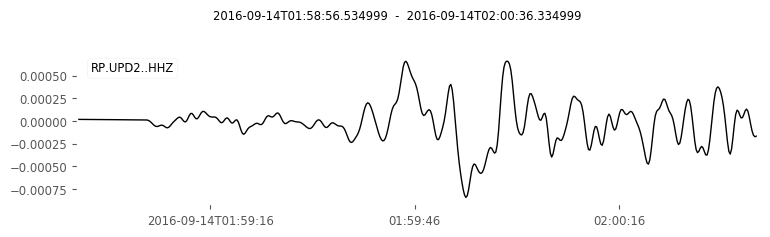

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


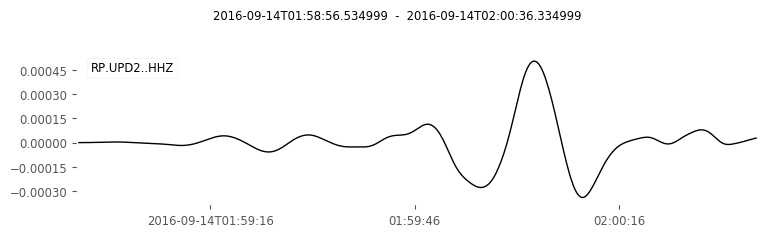

UPD2 Trim start time: 2016-09-14T01:58:56.503951Z Trim end time: 2016-09-14T02:00:36.303951Z
UPD2 Resampled to: dt= 0.2 number of points= 500
Trace number 24/24 in stream traces
6 arrivals
	P phase arrival at 40.257 seconds
	P phase arrival at 45.130 seconds
	P phase arrival at 45.370 seconds
	S phase arrival at 70.748 seconds
	S phase arrival at 76.101 seconds
	S phase arrival at 76.508 seconds


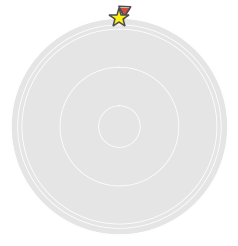

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Raw trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


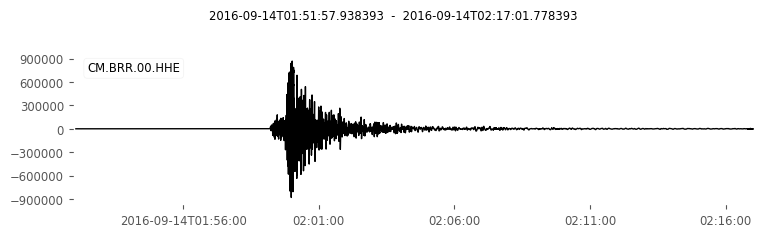

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Removed response XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


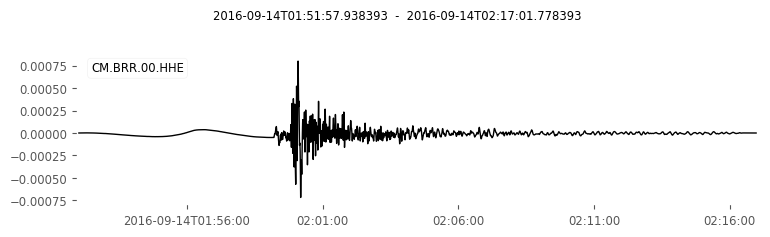

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Interpolated trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


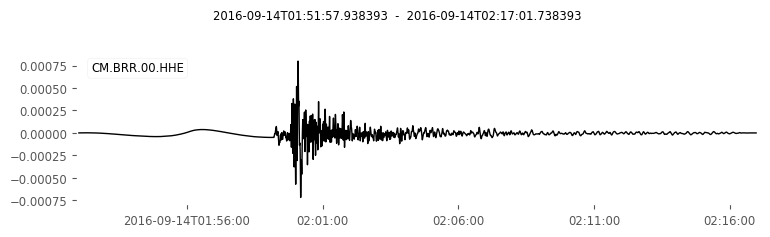

XXXXXXXXXXXXXXXXXXXXXXXXX Trimed trace before and after p-arrival XXXXXXXXXXXXXXXXXXXXXX


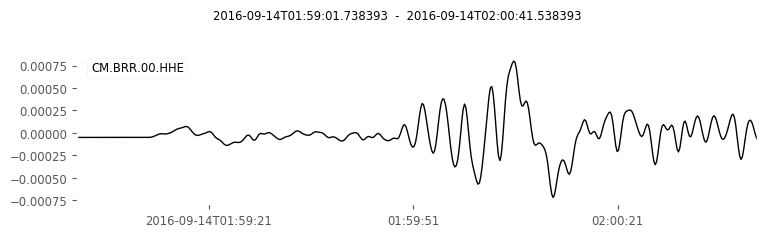

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX Filtered Trace XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


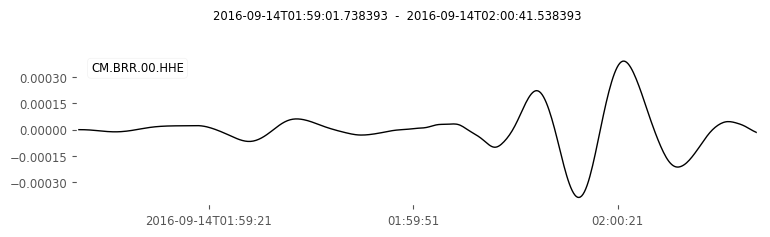

BRR Trim start time: 2016-09-14T01:59:01.827293Z Trim end time: 2016-09-14T02:00:41.627293Z
BRR Resampled to: dt= 0.2 number of points= 500
Data already rotated for station CBOC
Data already rotated for station PAL
Data already rotated for station PTB
Data already rotated for station UPD2
Data already rotated for station HEL
Data already rotated for station ZAR
Data already rotated for station BRR
Data already rotated for station NOR
24 Trace(s) in Stream:
CM.CBOC.00.HHZ | 2016-09-14T01:58:45.858393Z - 2016-09-14T02:00:25.658393Z | 5.0 Hz, 500 samples
CM.CBOC.00.HHE | 2016-09-14T01:58:45.788393Z - 2016-09-14T02:00:25.588393Z | 5.0 Hz, 500 samples
CM.CBOC.00.HHN | 2016-09-14T01:58:45.868393Z - 2016-09-14T02:00:25.668393Z | 5.0 Hz, 500 samples
CM.PAL.00.HHN  | 2016-09-14T01:58:58.608393Z - 2016-09-14T02:00:38.408393Z | 5.0 Hz, 500 samples
CM.PAL.00.HHE  | 2016-09-14T01:58:58.648394Z - 2016-09-14T02:00:38.448394Z | 5.0 Hz, 500 samples
CM.PAL.00.HHZ  | 2016-09-14T01:58:58.698393Z - 2016-09

In [7]:
respath=directory+"pz_files/Vel/" # Path to folder of RESP instrument response files
# Check at the beginning of the function nearFieldProcessing for additional signal processing parameters
streamNF=nearFieldProcessing(traces,respath,cat=cat,secBeforeP=10,event_depth=event_depth,
                        event_longitude=event_longitude, event_latitude=event_latitude,
                        starttime=starttime,endtime=endtime,Plot=True)

# To check if all traces have the right sampling rate and number of points
# Data need to be rotated to ENZ frame of reference: *HZ, *HE, *HN
# Use streamNF.plot() to plot them if needed)
print(streamNF.__str__(extended=True))

# Traces are placed in folder and the inventory with the chosen traces is created
# Traces placed in directory directory+projectName+data+waveforms
placeObservedTraces(directory,projectName,streamNF)


Text(0.5,1,'Station map to use, around Colombia')

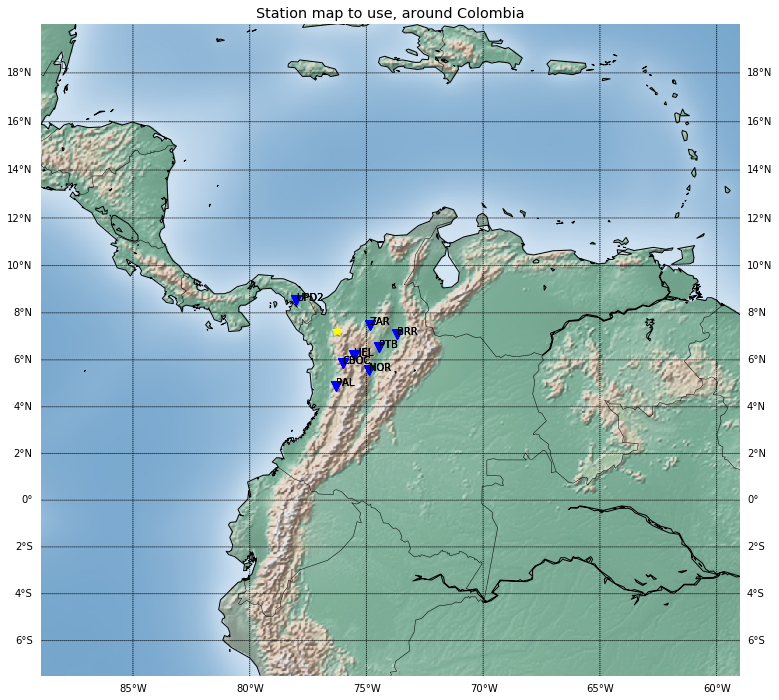

In [8]:
# Plot of the stations to use

plt.figure(figsize=(16,12))
stamap = Basemap(projection='merc', lat_0 = 4.5, lon_0 = -73,
                 resolution = 'l', area_thresh = 0.1,
                 llcrnrlon=-89, llcrnrlat=-7.5,
                 urcrnrlon=-59, urcrnrlat=20)
#stamap.drawmapboundary()
stamap.shadedrelief()
stamap.drawcoastlines()
stamap.drawcountries()
stamap.drawmeridians(np.arange(0, 360, 5),labels=[1,1,0,1])
stamap.drawparallels(np.arange(-90, 90, 2),labels=[1,1,0,1])

#plot the hypocenter
jj1,hh1 = stamap(event_longitude ,event_latitude)
stamap.plot(jj1,hh1, '*',markersize=10, color='yellow')

for i in range(len(streamNF)):
    x,y = stamap(streamNF[i].stats.longitude, streamNF[i].stats.latitude)
    stamap.plot(x, y, 'bv', markersize=10)
    plt.text(x, y, streamNF[i].stats.station)
                
plt.title("Station map to use, around Colombia")


### Mudpy
At the same time we will produce the input files for the program Mudpy. We will generate the subfaults by using instaseis finite_source function which will give us the locations of the point sources.

In [9]:
# Fault plane parameters
strike,dip,rake=132, 43, 180
evlat1=event_latitude
evlon1=event_longitude
nl=17 #subfaults across length.
nw=17 #subfaults across width.
fault_length_m=50000 # Fault dimension along strike in m
fault_width_m=50000 # Fault dimention along dip in m
rise_time=1.1 # Rise time of subfault source functions in s


finite_source=instaseis.source.FiniteSource.from_Haskell(
        event_latitude, event_longitude, depth_in_m=event_depth*1000,
        strike=strike, dip=dip, rake=rake, M0=7.743e+17,
        fault_length=fault_length_m, fault_width=fault_width_m, rupture_velocity=2500,
        nl=nl, nw=nw,trise=rise_time, tfall=rise_time, dt=0.2, planet_radius=6371000.0, 
        origin_time=cat[0].origins[0].time)

print(finite_source)
print('A point source can be computed as a sum of all point sources weighted by their moment. Instaseis computes the centroid moment tensor by summing over all point sources weighted by their scalar moment')
# Prepare the source time functions (stf)
finite_source.resample_sliprate(dt=finite_source[0].dt, nsamp=512)

finite_source.compute_centroid()
finite_source.CMT.origin_time=cat[0].origins[0].time
print(finite_source.CMT)

print('The hypocenter and epicenter can be found as the fault patch that ruptures first based on the point source that has the smallest timeshift:')
finite_source.find_hypocenter()
print('hypocenter latitude: '+ repr(finite_source.hypocenter_latitude)+
      ', longitude: ' + repr(finite_source.hypocenter_longitude)+
      ', depth: '+ repr(finite_source.hypocenter_depth_in_m / 1e3))


Instaseis Finite Source:
	Moment Magnitude     : 5.86
	Scalar Moment        :   7.74e+17 Nm
	#Point Sources       : 289
	Rupture Duration     :   18.8 s
	Time Shift           :    0.0 s
	Min Depth            : 3886.2 m
	Max Depth            : 36023.6 m
	Hypocenter Depth     : 36023.6 m
	Min Latitude         :    7.0 deg
	Max Latitude         :    7.5 deg
	Hypocenter Latitude  :    7.2 deg
	Min Longitude        :  -76.5 deg
	Max Longitude        :  -76.0 deg
	Hypocenter Longitude :  -76.0 deg

A point source can be computed as a sum of all point sources weighted by their moment. Instaseis computes the centroid moment tensor by summing over all point sources weighted by their scalar moment
Instaseis Source:
	Origin Time      : 2016-09-14T01:58:31.570000Z
	Longitude        :  -76.3 deg
	Latitude         :    7.2 deg
	Depth            : 2.0e+01 km km
	Moment Magnitude :   5.86
	Scalar Moment    :   7.74e+17 Nm
	Mrr              :   2.65e+11 Nm
	Mtt              :  -5.25e+17 Nm
	Mpp        

### Now we plot the subfault with the relocated aftershocks.
We will use these locations also to produce the input for the program mudpy.
Run the following snipped once or just after running the previous, otherwise the min depth will change.

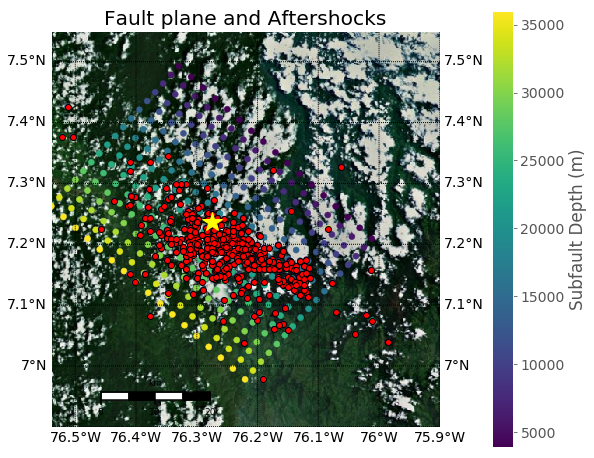

The colors in the fault plane represent their depth. Max depth(km)=36.0 Min Depth(km)= 3.88


In [12]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

fig, ax = plt.subplots(figsize=(8, 8))
map = Basemap(llcrnrlon=-76.54,llcrnrlat=6.9,
              urcrnrlon=-75.9,urcrnrlat=7.55,
              rsphere=(6378137.00,6356752.3142),resolution='c',projection='merc',
              lat_0=evlat1,lon_0=evlon1, suppress_ticks=True,epsg = 3395)


map.drawparallels(np.arange(-90,90,0.1),labels=[1,1,0,1])
map.drawmeridians(np.arange(-100,0,0.1),labels=[1,1,0,1])
map.etopo()
map.drawmapscale(-76.3686, 6.95,-76.1686+0.8,6.95,20, barstyle='fancy', units='km', labelstyle='simple',
                 fillcolor1='w', fillcolor2='black', fontcolor='black')

map.arcgisimage(server='http://server.arcgisonline.com/ArcGIS', service='ESRI_Imagery_World_2D', xpixels = 500, ypixels = 500)

diff=finite_source.max_depth_in_m-finite_source.min_depth_in_m
smallest=finite_source.min_depth_in_m
depth_=finite_source.max_depth_in_m

#Plot the fault plane
depth_arr=np.zeros(nw*nl)
lng_arr=np.zeros(nw*nl)
lat_arr=np.zeros(nw*nl)
for i in range(nl*nw):
    depth_arr[i]=finite_source[i].depth_in_m
    lng_arr[i]=finite_source[i].longitude
    lat_arr[i]=finite_source[i].latitude
    
lng_FP,lat_FP=map(lng_arr,lat_arr)
plt.scatter(lng_FP,lat_FP,c=depth_arr)
cbar=plt.colorbar(pad=0.1, shrink=0.8)
cbar.set_label('Subfault Depth (m)')

#Read Aftershocks
AfterShocks=np.loadtxt(DataDir+'Aftershocks.txt')
lon_AS=AfterShocks[:,0]
lat_AS=AfterShocks[:,1]
depth_AS=AfterShocks[:,2]
jj2,hh2= map(lon_AS,lat_AS)
plt.scatter(jj2,hh2, c=depth_AS)
map.plot(jj2,hh2,'o', markersize=6, markeredgecolor="black", color='red')

#plot the hypocenter
jj1, hh1 = map(event_longitude ,event_latitude)
map.plot(jj1,hh1, '*',markersize=20, color='yellow')

plt.title(r'Fault plane and Aftershocks')
plt.tight_layout()
plt.show()

print('The colors in the fault plane represent their depth. Max depth(km)='+repr(finite_source.max_depth_in_m/1000)[:4]+' Min Depth(km)= '+repr(finite_source.min_depth_in_m/1000)[:4])


Now we generate the files that Mudpy reads as an input for generating the green functions and synthetics. It needs as an input the subfault locations and depth which we calculated previously. It makes a plot of how the program reads the fault plane in order to check that it is as we want it to be.

We make sure that the event data is the same that the program will use to calculate the synthetics and perform the inversion. Numbers of subfaults across length nl and across width nw are entered to the run file. 

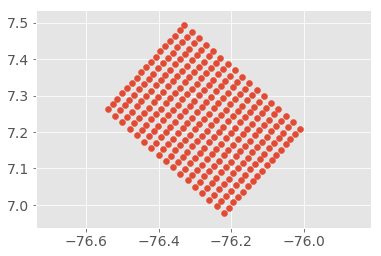

epicenter=np.array([ -76.275 , 7.236 ,20])



In [17]:
# Create .gflist file in folder tree (directory+projectName+data+station_info+*.gflist)
greenFunctionList(streamNF,directory,projectName)

# Create .fault file in folder tree (directory+projectName+data+model_info+*.fault)
faultParameters(finite_source,directory,projectName)

#Open .inv.py file to do any required modification.
#Choose carefully spatial and temporal regularization coefficients
prepareRunFile(nl,nw,event_longitude,event_latitude,event_depth)

## Now we run the inversion for the near-field

### WARNING!!!!!!! if the path to the green functions ProjectName/GFs/dynamic/vmodel/*.grn is too long the syn.c code will return an ERROR (Abort trap: 6) as the code assigns a fixed memory space for the pathname string.

In [18]:
# Make sure that you updated the slipInversion.inv.py file (ex: velocity model name, rupture
# speed, range reg. parameters, solver type, displacement time series band-pass filter)
# For a clean start, remove the files in the following folders:
# Generation of Green's function by MudPy in directory+projectName+GFs+dynamic+vmodel.subfaults
# Generation of synthetics by MudPy in directory+projectName+GFs+dynamic+vmodel.subfaults
# Generation of inversion files by MudPy in directory+projectName+output+inverse_models+models
# Mudpy automatically add 50 samples before synthetic first arrival

# Common error: synthetic end time is before the data end time.
# -> Increase NFFT number in slipInversion.inv.py (needs to be a power of 2 I think)

runInversion(directory,projectName,makeGreen=True,makeSynthetics=True,invert=True)


This might take some time, go grab something to eat ....
Displacememnt GFs requested...
('MPI: Starting GFs computation on', 2, 'CPUs\n')
mpiexec -n 2 python /Users/jeanbaptistetary/Documents/DavidNaranjo/MudPy/src/python/mudpy/parallel.py run_parallel_green /Users/jeanbaptistetary/Documents/SSI/ NearField /Users/jeanbaptistetary/Documents/SSI/NearField/data/station_info/temp.sta NF-VelMod.mod 0.2 1024 0 0.2 0 1 10 False False
Running all processes with:
        home = /Users/jeanbaptistetary/Documents/SSI/
        project_name = NearField
        station_file = /Users/jeanbaptistetary/Documents/SSI/NearField/data/station_info/temp.sta
        model_name = NF-VelMod.mod
        static = 0
        tsunami = False
        dt = 0.200
        NFFT = 1024
        dk = 0.200
        pmin = 0.000
        pmax = 1.000
        kmax = 10.000
        insar = False
        
('MPI: processor #', 1, 'is now working on subfault', 2, '(', 1, '/', 144, ')')
('MPI: processor #', 0, 'is now working on su

('MPI: processor #', 0, 'is now working on subfault', 91, '(', 46, '/', 145, ')')
('MPI: processor #', 1, 'is now working on subfault', 92, '(', 46, '/', 144, ')')
('MPI: processor #', 0, 'is now working on subfault', 93, '(', 47, '/', 145, ')')
('MPI: processor #', 1, 'is now working on subfault', 94, '(', 47, '/', 144, ')')
('MPI: processor #', 0, 'is now working on subfault', 95, '(', 48, '/', 145, ')')
('MPI: processor #', 1, 'is now working on subfault', 96, '(', 48, '/', 144, ')')
('MPI: processor #', 0, 'is now working on subfault', 97, '(', 49, '/', 145, ')')
('MPI: processor #', 1, 'is now working on subfault', 98, '(', 49, '/', 144, ')')
('MPI: processor #', 0, 'is now working on subfault', 99, '(', 50, '/', 145, ')')
('MPI: processor #', 1, 'is now working on subfault', 100, '(', 50, '/', 144, ')')
('MPI: processor #', 0, 'is now working on subfault', 101, '(', 51, '/', 145, ')')
('MPI: processor #', 1, 'is now working on subfault', 102, '(', 51, '/', 144, ')')
('MPI: proces

('MPI: processor #', 1, 'is now working on subfault', 190, '(', 95, '/', 144, ')')
('MPI: processor #', 0, 'is now working on subfault', 191, '(', 96, '/', 145, ')')
('MPI: processor #', 1, 'is now working on subfault', 192, '(', 96, '/', 144, ')')
('MPI: processor #', 0, 'is now working on subfault', 193, '(', 97, '/', 145, ')')
('MPI: processor #', 1, 'is now working on subfault', 194, '(', 97, '/', 144, ')')
('MPI: processor #', 0, 'is now working on subfault', 195, '(', 98, '/', 145, ')')
('MPI: processor #', 1, 'is now working on subfault', 196, '(', 98, '/', 144, ')')
('MPI: processor #', 0, 'is now working on subfault', 197, '(', 99, '/', 145, ')')
('MPI: processor #', 1, 'is now working on subfault', 198, '(', 99, '/', 144, ')')
('MPI: processor #', 0, 'is now working on subfault', 199, '(', 100, '/', 145, ')')
('MPI: processor #', 1, 'is now working on subfault', 200, '(', 100, '/', 144, ')')
('MPI: processor #', 0, 'is now working on subfault', 201, '(', 101, '/', 145, ')')
(

('MPI: processor #', 0, 'is now working on subfault', 287, '(', 144, '/', 145, ')')
('MPI: processor #', 0, 'is now working on subfault', 289, '(', 145, '/', 145, ')')
Displacement synthetics requested
('MPI: Starting synthetics computation on', 2, 'CPUs\n')
mpiexec -n 2 python /Users/jeanbaptistetary/Documents/DavidNaranjo/MudPy/src/python/mudpy/parallel.py run_parallel_synthetics /Users/jeanbaptistetary/Documents/SSI/ NearField /Users/jeanbaptistetary/Documents/SSI/NearField/data/station_info/temp.sta NF-VelMod.mod 1 0 False 2016-09-14T01:58:31.000000Z 0 None False False False 45000000000.0
Running all processes with:
        home = /Users/jeanbaptistetary/Documents/SSI/
        project_name = NearField
        station_file = /Users/jeanbaptistetary/Documents/SSI/NearField/data/station_info/temp.sta
        model_name = NF-VelMod.mod
        integrate = 1
        static = 0
        tsunami = False
        time_epi = 2016-09-14T01:58:31.000000Z
        beta = 0
        custom_stf = No

Processor 0 is working on subfault 131 and 8 stations 
Processor 1 is working on subfault 134 and 8 stations 
Processor 0 is working on subfault 133 and 8 stations 
Processor 1 is working on subfault 136 and 8 stations 
Processor 0 is working on subfault 135 and 8 stations 
Processor 1 is working on subfault 138 and 8 stations 
Processor 0 is working on subfault 137 and 8 stations 
Processor 1 is working on subfault 140 and 8 stations 
Processor 1 is working on subfault 142 and 8 stations 
Processor 0 is working on subfault 139 and 8 stations 
Processor 0 is working on subfault 141 and 8 stations 
Processor 1 is working on subfault 144 and 8 stations 
Processor 1 is working on subfault 146 and 8 stations 
Processor 0 is working on subfault 143 and 8 stations 
Processor 1 is working on subfault 148 and 8 stations 
Processor 0 is working on subfault 145 and 8 stations 
Processor 1 is working on subfault 150 and 8 stations 
Processor 0 is working on subfault 147 and 8 stations 
Processor 

Processor 0 is working on subfault 279 and 8 stations 
Processor 1 is working on subfault 284 and 8 stations 
Processor 0 is working on subfault 281 and 8 stations 
Processor 1 is working on subfault 286 and 8 stations 
Processor 0 is working on subfault 283 and 8 stations 
Processor 1 is working on subfault 288 and 8 stations 
Processor 0 is working on subfault 285 and 8 stations 
Processor 0 is working on subfault 287 and 8 stations 
Processor 0 is working on subfault 289 and 8 stations 
Assembling displacement waveforms from CBOC into data vector.
Assembling displacement waveforms from PAL into data vector.
Assembling displacement waveforms from PTB into data vector.
Assembling displacement waveforms from UPD2 into data vector.
Assembling displacement waveforms from HEL into data vector.
Assembling displacement waveforms from ZAR into data vector.
Assembling displacement waveforms from BRR into data vector.
Assembling displacement waveforms from NOR into data vector.
Assembling G fr

...Working on station #8 of 8
... ... 500 data points left over after decimation
Working on window 9
Aligning GFs and resampling to data times...
...Working on station #1 of 8
... ... 500 data points left over after decimation
...Working on station #2 of 8
... ... 500 data points left over after decimation
...Working on station #3 of 8
... ... 500 data points left over after decimation
...Working on station #4 of 8
... ... 500 data points left over after decimation
...Working on station #5 of 8
... ... 500 data points left over after decimation
...Working on station #6 of 8
... ... 500 data points left over after decimation
...Working on station #7 of 8
... ... 500 data points left over after decimation
...Working on station #8 of 8
... ... 500 data points left over after decimation
Working on window 10
Aligning GFs and resampling to data times...
...Working on station #1 of 8
... ... 500 data points left over after decimation
...Working on station #2 of 8
... ... 500 data points left 

Making first derivative temporal regularization matrix...
Preprocessing wall time was 0:08:56.297335

--- RUNNING INVERSIONS ---

Running inversion 1 of 200 at regularization levels: ls =0.001 , lt = 0.0001
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0000.inv
... inversion wall time was 0:00:18.293377, total wall time elapsed is 0:00:18.293391
Running inversion 2 of 200 at regularization levels: ls =0.0012742749857031334 , lt = 0.0001
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0001.inv
... inversion wall time was 0:00:17.679169, total wall time elapsed is 0:00:35.972586
Running inversion 3 of 200 at regularization levels: ls =0.00162377673918872

... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0020.inv
... inversion wall time was 0:00:19.143486, total wall time elapsed is 0:14:03.235850
Running inversion 22 of 200 at regularization levels: ls =0.0012742749857031334 , lt = 0.00021544346900318845
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0021.inv
... inversion wall time was 0:00:20.155277, total wall time elapsed is 0:14:23.391179
Running inversion 23 of 200 at regularization levels: ls =0.001623776739188721 , lt = 0.00021544346900318845
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/

... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0040.inv
... inversion wall time was 0:00:19.524802, total wall time elapsed is 0:27:49.933135
Running inversion 42 of 200 at regularization levels: ls =0.0012742749857031334 , lt = 0.00046415888336127773
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0041.inv
... inversion wall time was 0:00:18.955828, total wall time elapsed is 0:28:08.889037
Running inversion 43 of 200 at regularization levels: ls =0.001623776739188721 , lt = 0.00046415888336127773
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/

... inversion wall time was 0:01:31.937000, total wall time elapsed is 0:41:15.632961
Running inversion 61 of 200 at regularization levels: ls =0.001 , lt = 0.001
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0060.inv
... inversion wall time was 0:00:18.678287, total wall time elapsed is 0:41:34.311303
Running inversion 62 of 200 at regularization levels: ls =0.0012742749857031334 , lt = 0.001
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0061.inv
... inversion wall time was 0:00:18.539656, total wall time elapsed is 0:41:52.850983
Running inversion 63 of 200 at regularization levels: ls =0.001623776739188721 , lt = 0.001
... calcualting variance red

... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0080.inv
... inversion wall time was 0:00:24.456139, total wall time elapsed is 0:55:20.774154
Running inversion 82 of 200 at regularization levels: ls =0.0012742749857031334 , lt = 0.002154434690031882
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0081.inv
... inversion wall time was 0:00:23.838416, total wall time elapsed is 0:55:44.612596
Running inversion 83 of 200 at regularization levels: ls =0.001623776739188721 , lt = 0.002154434690031882
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Docu

... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0100.inv
... inversion wall time was 0:00:42.665490, total wall time elapsed is 1:10:02.396398
Running inversion 102 of 200 at regularization levels: ls =0.0012742749857031334 , lt = 0.004641588833612777
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0101.inv
... inversion wall time was 0:00:44.656023, total wall time elapsed is 1:10:47.052447
Running inversion 103 of 200 at regularization levels: ls =0.001623776739188721 , lt = 0.004641588833612777
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Do

... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0120.inv
... inversion wall time was 0:01:15.871855, total wall time elapsed is 1:29:17.642206
Running inversion 122 of 200 at regularization levels: ls =0.0012742749857031334 , lt = 0.01
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0121.inv
... inversion wall time was 0:01:15.966505, total wall time elapsed is 1:30:33.608738
Running inversion 123 of 200 at regularization levels: ls =0.001623776739188721 , lt = 0.01
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inv

... inversion wall time was 0:02:01.880391, total wall time elapsed is 1:58:36.719182
Running inversion 142 of 200 at regularization levels: ls =0.0012742749857031334 , lt = 0.021544346900318822
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0141.inv
... inversion wall time was 0:02:11.567887, total wall time elapsed is 2:00:48.287137
Running inversion 143 of 200 at regularization levels: ls =0.001623776739188721 , lt = 0.021544346900318822
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0142.inv
... inversion wall time was 0:02:11.466312, total wall time elapsed is 2:02:59.753478
Running inversion 144 of 200 at regularization levels: ls =0.002069138081

... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0160.inv
... inversion wall time was 0:02:52.408031, total wall time elapsed is 2:42:57.377407
Running inversion 162 of 200 at regularization levels: ls =0.0012742749857031334 , lt = 0.046415888336127774
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0161.inv
... inversion wall time was 0:02:56.793796, total wall time elapsed is 2:45:54.171247
Running inversion 163 of 200 at regularization levels: ls =0.001623776739188721 , lt = 0.046415888336127774
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.01

... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0180.inv
... inversion wall time was 0:03:30.366912, total wall time elapsed is 3:42:18.227349
Running inversion 182 of 200 at regularization levels: ls =0.0012742749857031334 , lt = 0.1
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inverse_models/models/mutata.0181.inv
... inversion wall time was 0:03:41.039153, total wall time elapsed is 3:45:59.266528
Running inversion 183 of 200 at regularization levels: ls =0.001623776739188721 , lt = 0.1
... calcualting variance reduction...
... computing 2d-ABIC
... computing and saving synthetics...
... writing model results to file /Users/jeanbaptistetary/Documents/SSI/NearField/output/inver

## Plotting the Results - Near Field / Regional Inversion

Which iteration you do want to plot (0-199)?112
Inversion number: 0112
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing


/anaconda2/envs/obspy/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


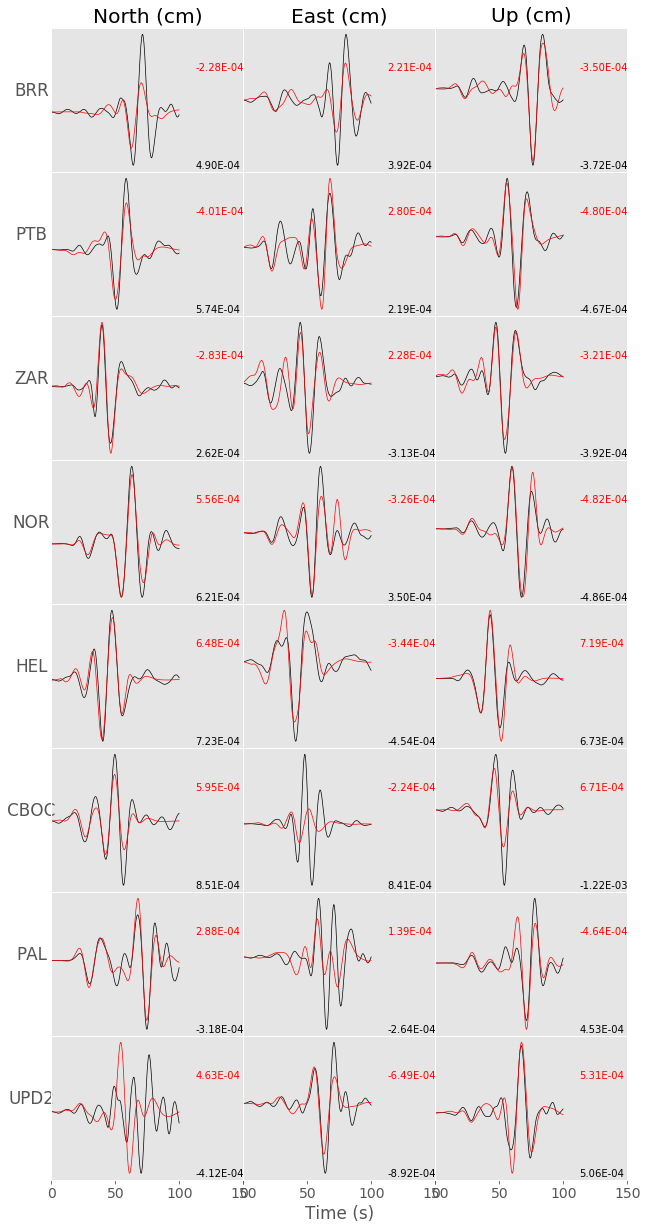

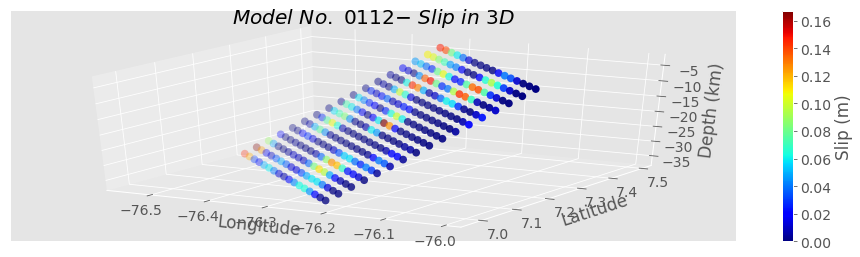

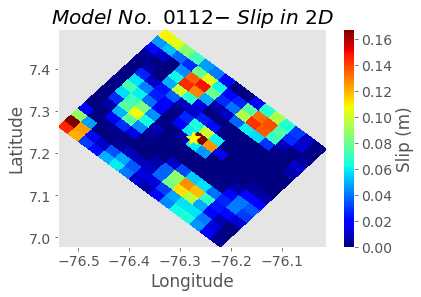

Mean slip in m is: 0.03177682607780958
np.logspace(-3,-1,num=20)#Se np.logspace(-4,-1,num=10)#S
reg_coef: t,s [-4, -1, 10] [-3, -1, 20]
Min ABIC= -114026.9352696336 20
The minimum ABIC is at dot: lambda_s= 1 and lambda_t= 2
Chosen ABIC= -112164.0873023142
The green triangle shows the selected regulatization coefficients
The green star shows the regulatization coeficients with minimum ABIC


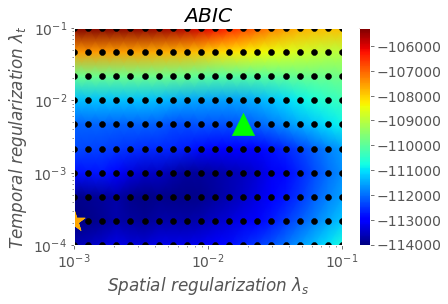

... working on subfault 0 of 289
... working on subfault 10 of 289
... working on subfault 20 of 289
... working on subfault 30 of 289
... working on subfault 40 of 289
... working on subfault 50 of 289
... working on subfault 60 of 289
... working on subfault 70 of 289
... working on subfault 80 of 289
... working on subfault 90 of 289
... working on subfault 100 of 289
... working on subfault 110 of 289
... working on subfault 120 of 289
... working on subfault 130 of 289
... working on subfault 140 of 289
... working on subfault 150 of 289
... working on subfault 160 of 289
... working on subfault 170 of 289
... working on subfault 180 of 289
... working on subfault 190 of 289
... working on subfault 200 of 289
... working on subfault 210 of 289
... working on subfault 220 of 289
... working on subfault 230 of 289
... working on subfault 240 of 289
... working on subfault 250 of 289
... working on subfault 260 of 289
... working on subfault 270 of 289
... working on subfault 280 of 

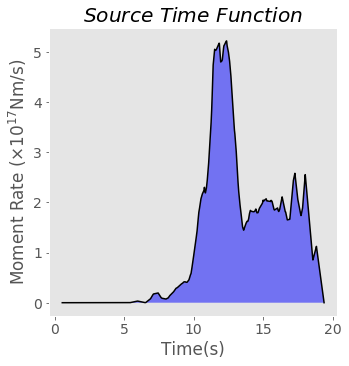

Do you want to plot another iteration (y/n)?n


In [11]:
# Plots of the main results for a given iteration
# Including: waveform fit between synthetics and observed data, slip distribution, 2d ABIC plot, STF
# The figures will be saved in directory+projectName+plots
home=directory
project=projectName
run_name='mutata'

epi=[event_longitude, event_latitude]
dimslip=[nl,nw]
# The plotting function for the source time function in MudPy has a bug in it. See the Matlab code to get the correct
# STF
plotResults(home,project,run_name,epi,dimslip,maxt=150,Plotsyn=True,Plotsli=True,Plotabc=True)



/Users/jeanbaptistetary/Documents/DavidNaranjo/MudPy/src/python/mudpy/view.py:2742: RuntimeWarning: invalid value encountered in divide
  ds=ds/((ds**2+ss**2)**0.5)


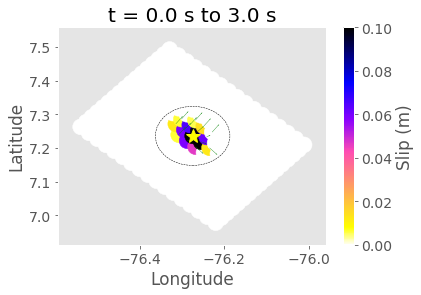

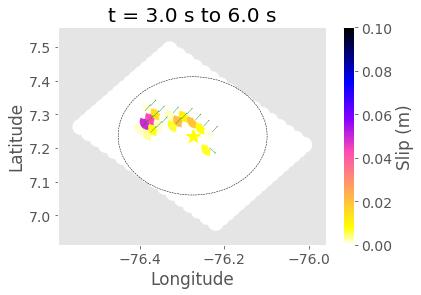

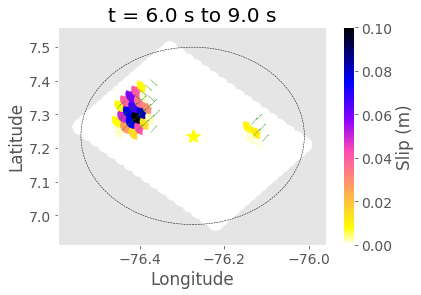

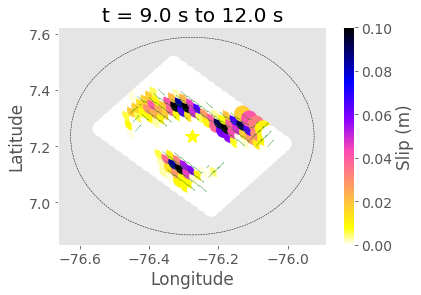

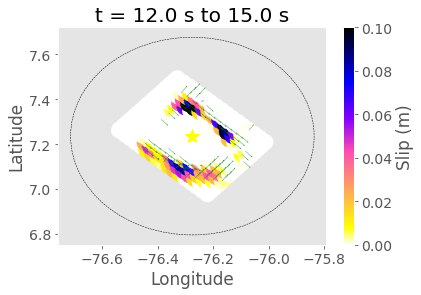

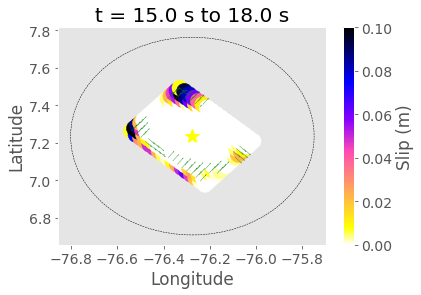

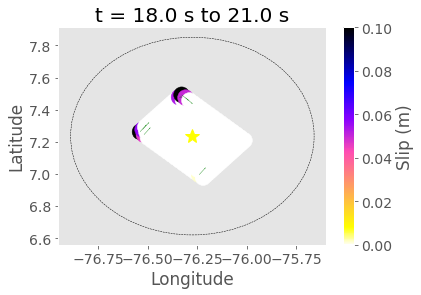

... working on subfault 0 of 289
... working on subfault 10 of 289
... working on subfault 20 of 289
... working on subfault 30 of 289
... working on subfault 40 of 289
... working on subfault 50 of 289
... working on subfault 60 of 289
... working on subfault 70 of 289
... working on subfault 80 of 289
... working on subfault 90 of 289
... working on subfault 100 of 289
... working on subfault 110 of 289
... working on subfault 120 of 289
... working on subfault 130 of 289
... working on subfault 140 of 289
... working on subfault 150 of 289
... working on subfault 160 of 289
... working on subfault 170 of 289
... working on subfault 180 of 289
... working on subfault 190 of 289
... working on subfault 200 of 289
... working on subfault 210 of 289
... working on subfault 220 of 289
... working on subfault 230 of 289
... working on subfault 240 of 289
... working on subfault 250 of 289
... working on subfault 260 of 289
... working on subfault 270 of 289
... working on subfault 280 of 

(array([[13.3083    , 13.30890506, 13.30951012, ..., 19.35708988,
         19.35769494, 19.3583    ],
        [12.5059    , 12.50650506, 12.50711012, ..., 18.55468988,
         18.55529494, 18.5559    ],
        [11.7625    , 11.76310506, 11.76371012, ..., 17.81128988,
         17.81189494, 17.8125    ],
        ...,
        [11.765     , 11.76560506, 11.76621012, ..., 17.81378988,
         17.81439494, 17.815     ],
        [12.5065    , 12.50710506, 12.50771012, ..., 18.55528988,
         18.55589494, 18.5565    ],
        [13.3104    , 13.31100506, 13.31161012, ..., 19.35918988,
         19.35979494, 19.3604    ]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.42720019e+14, 7.13600094e+13, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.28621569e+14, 6.43107846e+13, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.31659110e+13, 2.15829555e+13, 0.00000000e+00],
        ...,


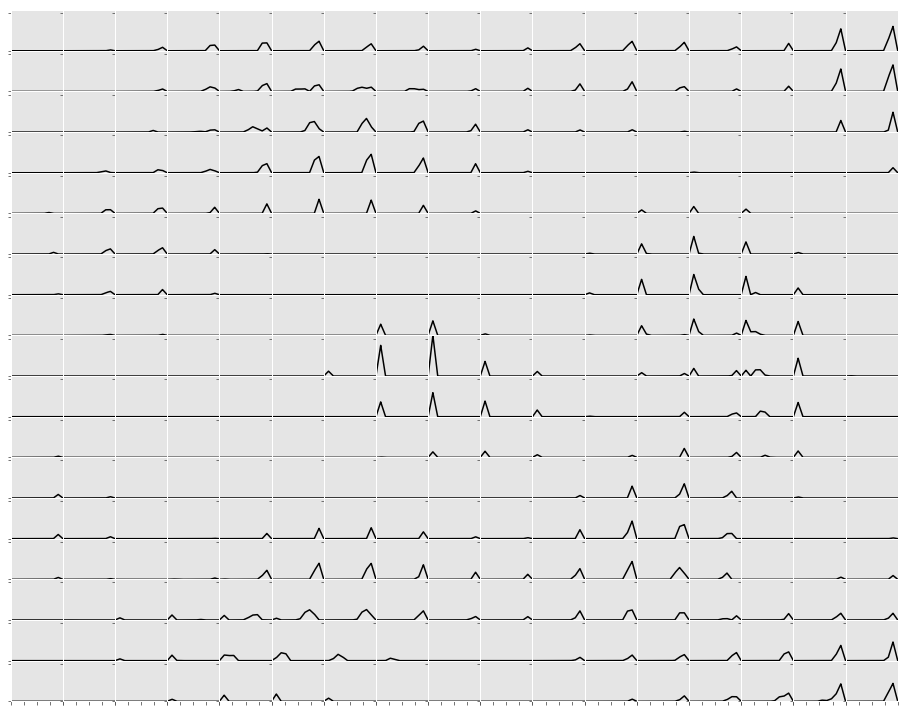

In [21]:
# Additional plotting:
from mudpy import view
# Path to rupture file to plot, path to plots and epicenter parameters
pathinv = directory+projectName+'/output/inverse_models/models/mutata.0112.inv'
pathout = directory+projectName+'/plots/'
epicenter=[event_longitude,event_latitude,event_depth]

# To get *.sliprate files (not needed yet)
#gmttools.make_sliprate_ruptfiles(pathinv,nl,nw,epicenter,pathout,15,3)
# To get *.slip files (not needed yet)
#gmttools.make_slip_slice(pathinv,nl,nw,epicenter,pathout,15,3)

# Slip as a function of time to check subfault activation timing (and rupture velocity)
# dt: duration of slices, delta_t: sampling interval of STF, cumul: if =0 cumulative slip else no, 
# vl and vm: lower and higher bounds of colorbar for plotting slip, vr: max rupture velocity in km/s
ruptslice(pathinv,pathout,epicenter,3,0.2,0,0,0.1,3.24)

# Source time functions for all subfaults
# None: covfile, 0: beta (rotate slip components), (5,1): rupture velocity limits, False/True: shade (true: very slow)
view.tile_moment(pathinv,epicenter,nl,nw,None,0,(5,1),False)
